Author: Lauren M. Sanders

Date: August 2020

Treehouse Childhood Cancer Initiative

University of California, Santa Cruz 

In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import itertools
import numpy as np
import random
import scanpy as sc
import math
from statannot import add_stat_annotation
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
import fastcluster
from fastcluster import linkage
from matplotlib.colors import rgb2hex, colorConverter
from matplotlib.pyplot import figure
import sys
sys.path.append('files/scoreCT/src/')
import scorect_api as ct

# Functions

In [101]:
# Code sourced from Treehouse CARE 

def make_expr_var_filters(dataframe, proportion_unexpressed, filter_level, zero_threshold):
    
    # unroll the count of zeroes
    max_ok_zeroes = len(dataframe.columns) * proportion_unexpressed

    # Is the count of items less than threshold within the acceptable count?
    def sufficiently_expressed(series, max_zeroes,threshold):
            return len(series[series <= threshold]) < max_zeroes

    # Gene & whether it is Keep (True) or too many zeroes (False)    
    withZeroes = dataframe.apply(sufficiently_expressed,
                            args=(max_ok_zeroes, zero_threshold),
                            axis=1)

    # Next, do variance filtering
    expression_filtered_compendium = dataframe[withZeroes]
    print(str(len(expression_filtered_compendium)) + ' genes remain after expression filter.')

    # Get the standard deviation
    variance = expression_filtered_compendium.apply(np.std, axis=1)
    cut_proportion = int(math.ceil(len(variance)*filter_level))
    keep_proportion = len(variance) - cut_proportion
    expression_and_variance_filtered = variance.nlargest(keep_proportion)
    print(str(len(expression_and_variance_filtered)) + ' genes remain after variance filter.')

    return expression_and_variance_filtered

In [210]:
def Heatmap(df, geneList, dictionary, title, filename, font, figuresize, pal, 
            colormap, geneCluster, vMinMax, ticks):
    '''
    Input: 
    1) df = the expression df (pandas df)
    2) geneList = list of genes 
    3) dictionary = dictionary to color groups 
    4) title = title for the plot (string)
    5) filename = filename to save figure (string path)
    6) font = font size (integer)
    7) seaborn color pallette (list)
    8) heatmap colors (string)
    9) whether to cluster rows (bool)
    10) vMinMax = a tuple, values to anchor the colormap (None,None) if none
    11) ticks = colorbar ticks, a list with 2 integers [0,1]
    '''

    sns.set(font_scale=font)
    # subset and reorder expression by dict samples
    dfSub = df.loc[df.index.intersection(geneList)][list(dictionary.keys())] 
    
    # reorder expression by gene list 
    dfSub = dfSub.reindex([x for x in geneList if x in dfSub.index])

    # remove any rows that are all 0's
    dfSub = dfSub.loc[(dfSub!=0).any(1)]
    
    # Reorder expression with sample info from the dictionary
    stat = pd.DataFrame(pd.Series(dictionary))
    stat.rename(columns={ stat.columns[0]: "Status" }, inplace=True)
    stat.sort_values(by="Status", inplace=True)
    dfSub = dfSub.reindex(columns=list(stat.index))
    statOnly = stat.pop('Status')
    
    # Heatmap
    lut = dict(zip(statOnly.unique(), pal))
    col_colors = statOnly.map(lut)   

    g = sns.clustermap(dfSub, cmap=colormap,
                        z_score=0, col_colors=col_colors, xticklabels=False, yticklabels=False,
                       vmin=vMinMax[0], vmax=vMinMax[1], cbar_kws={"ticks":ticks},
                        col_cluster=False, row_cluster=geneCluster, metric='correlation',
                       robust=True, square=False, figsize=figuresize).fig.suptitle(title)
   
    plt.savefig(filename,dpi=300,bbox_inches="tight")

In [103]:
def Boxplot(df, geneName, dictionary, title, yaxis, filename, figuresize, color, swarmSize, statLoc):
    '''
    1) expression pandas dataframe
    2) name of gene to plot (string)
    3) dictionary for grouping samples 
    4) plot title (string)
    5) y axis title (string)
    6) filename to save figure (string path)
    7) seaborn color pallette (list)
    8) figure size (tuple)
    9) size of swarmplot dots
    10) location of statistical annotations ('inside' or 'outside')
    '''
    
    sns.set(style="white", font_scale=1.1)
    sns.set_palette(color)
    fig, ax = plt.subplots(figsize=figuresize)
    
    plt.rc('font', size=20)          
    plt.rc('xtick', labelsize=25)    
    plt.rc('ytick', labelsize=25)    
    
    status = []
    values = []
    
    # Subset the expression df by gene and dictionary samples 
    dfSub = df.loc[[geneName]][list(dictionary.keys())]

    # Expression values to plot
    values = dfSub.loc[geneName].values.tolist()
    
    # Sample status for plotting 
    for name in list(dfSub.columns.values):
        if name in dictionary.keys():
            status.append(dictionary[name])
    
    plot_df = pd.DataFrame({'Status': status,'Value': values}, columns = ['Status','Value']).sort_values(by=['Status'])

    # Plot boxplot and swarmplot
    ax = sns.boxplot(ax=ax, x="Status", y="Value", hue="Status", data=plot_df, dodge=False, fliersize=2).set_title(title)
    ax = sns.swarmplot(x="Status", y="Value", color="black", data=plot_df, size=swarmSize)

    # Add statistical annotations
    orderForStatAnnot = sorted(list(itertools.combinations( list(sorted(plot_df['Status'].unique())), 2)))
    print(orderForStatAnnot)
    add_stat_annotation(ax, data=plot_df, x="Status", y="Value", order=list(sorted(plot_df['Status'].unique())),
                    box_pairs=orderForStatAnnot, 
                    test='Mann-Whitney', text_format='star', loc=statLoc, verbose=0,
                    line_offset_to_box=0.05, line_offset=0.001, line_height=0.01, text_offset=1)  
        
        
    sns.despine(offset=10, trim=True)
    ax.legend_.remove()
    ax.set_ylabel(yaxis, fontsize=30)
    ax.set_xlabel('')
    ax.set_title(title,fontsize=30)

    plt.savefig(filename,dpi=500,bbox_inches='tight')

In [104]:
def Swarmplot(df, geneName, dictionary, filename, dotColor):
    '''
    Inputs: 
    1) expression pandas dataframe
    2) gene name to plot (string)
    3) status dictionary for plotting
    4) filename (path string)
    5) a matplotlib color (string)
    '''
    
    fig_dims = (5,2) # for bulk RNA data from Field, fig2
    fig, ax = plt.subplots(figsize=fig_dims)
    
    status = []
    values = []
    
    # Subset the expression df by gene and dictionary samples 
    dfSub = df.loc[[geneName]][list(dictionary.keys())]

    # Expression values to plot
    values = dfSub.loc[geneName].values.tolist()
    
    # Sample status for plotting
    for name in list(dfSub.columns.values):
        if name in dictionary.keys():
            status.append(dictionary[name])
    
    plot_df = pd.DataFrame({'Status': status,'Value': values}, columns = ['Status','Value']).sort_values(by=['Status'])
    
    ax = sns.swarmplot(x="Status", y="Value", color=dotColor, data=plot_df, size=20) # normal size=3 #color=".25", 

    plt.rc('xtick', labelsize=25) 
    plt.rc('ytick', labelsize=25)  
    
    sns.despine(offset=10, trim=True)
    sns.despine(trim=False)
    ax.set(xlabel='',ylabel='')
    plt.savefig(filename,dpi=500,bbox_inches='tight')

In [105]:
def scoreCells(df, geneList):
    '''
    Inputs:
    1) expression pandas dataframe
    2) list of genes to use for scoring
    Outputs: a dataframe of normalized scores by cells
    '''
    
    #####################################
    # Create 30 Gene Bins by Expression #
    #####################################

    # Calculate aggregate expression for each gene in new dataframe
    agdf = pd.DataFrame(index=df.index)
    agdf['aggregate'] = df.mean(axis=1)
    agdf = agdf.sort_values(by='aggregate')

    # Get bin edges for 30 bins
    binSize = round(len(list(agdf['aggregate']))/30)
    i = 1
    j = 0
    bins = []
    bins.append(0.0)
    for j in range(1, 31):
        if j < 30:
            bins.append(list(agdf['aggregate'])[i*binSize])
        elif j == 30:
            bins.append( round(df.values.max()) ) 
        i += 1
    
    # Assign genes to bins based on aggregate expression
    labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    agdf['binned'] = pd.cut(agdf['aggregate'], bins=bins, labels=labels)
    
    # Make a dictionary relating gene and bin number
    binDict = agdf['binned'].to_dict() 
    
    # Make a dictionary relating bin and expression interval
    intervalDict = {}
    i = 0
    for x in bins: 
        try:
            intervalDict[i+1] = (x,bins[i+1])
            i += 1
        except IndexError:
            pass

    # Function to return the bin for each gene's expression in one cell
    def getBin(geneExp):
        for x in intervalDict:
            interval = intervalDict[x]
            if geneExp >= interval[0] and geneExp <= interval[1]:
                return(x)
 
    ###############################
    # Calculate Scores Using Bins #
    ###############################
            
    scoreDict = {}
    columns = list(df) 
    
    # Iterate through samples
    i = 0 
    for sam in columns:
        # Calculate non-normalized score 
        prelimScore = np.mean(list(df[sam].loc[df.index.intersection(geneList)])) 
        
        # Get control gene set (100 random genes from each real gene's bin)
        ctrlGeneSet = []    
        for gene in list(df[sam].loc[df.index.intersection(geneList)].index) : 
            geneBin = getBin( df[sam].loc[df.index.intersection(geneList)].loc[gene]  ) 
            ctrlGeneSet.extend(random.sample([x for x in list(binDict.keys()) if binDict[x] == geneBin], 100)) 
        
        # Calculate score for control gene set
        ctrlScore = np.mean(list(df[sam].loc[df.index.intersection(ctrlGeneSet)]))
        
        # Normalize score by control score and add to dictionary
        realScore = prelimScore - ctrlScore 
        scoreDict[sam] = realScore

        i += 1 
        if i == len(columns):
            break 
        
    # Convert scores dictionary to dataframe
    scores = pd.DataFrame.from_dict(scoreDict, orient = 'index').T
    
    # Normalize scores between 0-1 
    scoresNorm = scores.subtract(scores.min(axis=1), axis=0)\
      .divide(scores.max(axis=1) - scores.min(axis=1), axis=0)\
      .combine_first(scores)
    
    return(scoresNorm)

# Files

## Bulk Glioma RNA-seq
Source: Treehouse Cancer Compendium treehousegenomics.soe.ucsc.edu/public-data/

In [106]:
# bulk glioma RNA-seq matrix
phgg = pd.read_csv('files/pHGG.exp.log2tpm1.tsv',sep='\t',index_col=0)
phgg.shape

(58581, 78)

In [107]:
# bulk glioma metadata dictionary
phggDict = pd.read_csv('files/pHGG.metadata.csv').set_index('THID')['HistoneStatus'].to_dict()
len(phggDict)

78

## Single cell glioma RNA-seq
Source: GSE102130, PMID: 29674595

In [108]:
# filtered to remove 20% of lowest varying genes and genes not expressed in 80% of samples 
scGlioma = pd.read_csv('files/glioma.sc.filtered.log2.tsv',sep='\t',index_col=0)
scGlioma.shape

(10132, 3057)

In [160]:
scGliomaDict = pd.read_csv('files/glioma.sc.meta.2.csv',index_col=0)['Histone'].to_dict()
len(scGliomaDict)

3057

In [159]:
scGliomaPatientDict = pd.read_csv('files/glioma.sc.meta.2.csv',index_col=0)['Patient'].to_dict()
len(scGliomaPatientDict)

3057

## Glioma cell line RNA-seq
Source: dbGap phs000900.v1.p1, PMID: 25939062

In [110]:
cl = pd.read_csv('files/glioma.celllines.filtered.log2.tsv',sep='\t',index_col=0)
cl.shape

(24658, 11)

In [111]:
clDict = {
'THR13_0968_S03':'H3.3',
'THR13_0968_S04':'H3.3',
'THR13_0968_S05':'H3.3',
'THR13_0968_S06':'H3.3',

'THR13_0970_S02':'H3.1',
'THR13_0970_S03':'H3.1',
'THR13_0970_S04':'H3.1',
'THR13_0970_S05':'H3.1',

'THR13_0975_S01':'H3.3',
'THR13_0975_S02':'H3.3',
'THR13_0975_S03':'H3.3'
}

## Gene Lists

In [112]:
# list of genes differentially expressed by limma
limma = list(pd.read_csv('files/pHGG.limma.csv',index_col=0).index)
len(limma)

1905

In [113]:
# list of genes overexpressed in H3K27M bulk glioma cohort
lim = pd.read_csv('files/pHGG.limma.csv',index_col=0)
k27mUp = list(lim[(lim['DEStatus'] > 0)].index)
len(k27mUp)

1180

In [181]:
# EMT master gene list 
emtMaster = list(pd.read_csv('files/EMT.masterlist.txt',index_col=0,header=None).index)
len(emtMaster)

436

In [182]:
# EMT differentially expressed genes
emtDE = [x for x in limma if x in emtMaster]
len(emtDE)

50

In [116]:
# EMT completeness gene list 
emtCom = list(pd.read_csv('files/EMT.completeness.txt',index_col=0,header=None).index)
len(emtCom)

7

In [117]:
# Write out list of genes overexpressed in H3K27M bulk glioma cohort 
# that also pass organoid single cell expression filters
# with open('files/DE.UpinK.inOrganoids.041920.txt', 'w') as out:
#     out.write('\n'.join(list(scOrgFil.loc[scOrgFil.index.intersection(k27mUp)].index)))

## Bulk organoid RNA-seq
Source: GSE106245

In [118]:
bulk = pd.read_csv("files/organoid.bulk.log2tpm1.tsv",sep="\t",index_col=0)

In [119]:
# converted to gestational weeks
bulkDict = {}
bulkDict['w0 TPM'] = '1'
bulkDict['w1 TPM'] = '2'
bulkDict['w2 TPM'] = '3'
bulkDict['w3 TPM'] = '4'
bulkDict['w4 TPM'] = '5'
bulkDict['w5 TPM'] = '6'


In [120]:
# normalize each row between 0-1 
bulkNorm = bulk.subtract(bulk.min(axis=1), axis=0)\
  .divide(bulk.max(axis=1) - bulk.min(axis=1), axis=0)\
  .combine_first(bulk)


## Single cell organoid RNA-seq
Source: GSE106245

In [121]:
# unfiltered data (scanpy object created by merging the week2 and week5 expression)
scOrgAdata = sc.read_h5ad('files/organoid_raw_wk2wk5.h5ad')
# extract matrix
scOrg = pd.DataFrame(scOrgAdata.X, 
                     index=list(scOrgAdata.obs.index), 
                     columns=list(pd.DataFrame(scOrgAdata.var).index)).transpose()
scOrg.shape


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(59042, 7650)

In [122]:
# filter to remove 20% of lowest varying genes and genes not expressed in 90% of samples 
genesToKeep = list(make_expr_var_filters(scOrg, 0.9, 0.2, 0).index)
scOrgFil = scOrg.loc[genesToKeep] # subset to genes that passed filters
scOrgFil = scOrgFil.groupby(scOrgFil.index).mean() # average any duplicate genes
scOrgFil.shape

7863 genes remain after expression filter.
6290 genes remain after variance filter.


(6290, 7650)

In [123]:
# create cell type dictionary, rename cell types for correct plotting order
scOrgDict = {}
with open('files/celltypes_wk2wk5_names.csv', 'r') as f:
    for line in f:
        line = line.rstrip().split(',')
        if line[1] == 'Neuroepithelium':
            scOrgDict[line[0]] = 'ANeural \nepithelium'
        if line[1] == 'Early radial glia':
            scOrgDict[line[0]] = 'Early \nradial glia'
        if line[1] == 'Intermediate Progenitors':
            scOrgDict[line[0]] = 'Intermediate \nprogenitors'
        if line[1] == 'Late radial glia':
            scOrgDict[line[0]] = 'Late \nradial glia'
        if line[1] == 'Neurons':
            scOrgDict[line[0]] = 'Neurons'       
len(scOrgDict)

7257

# Figure 1

## Figure 1B

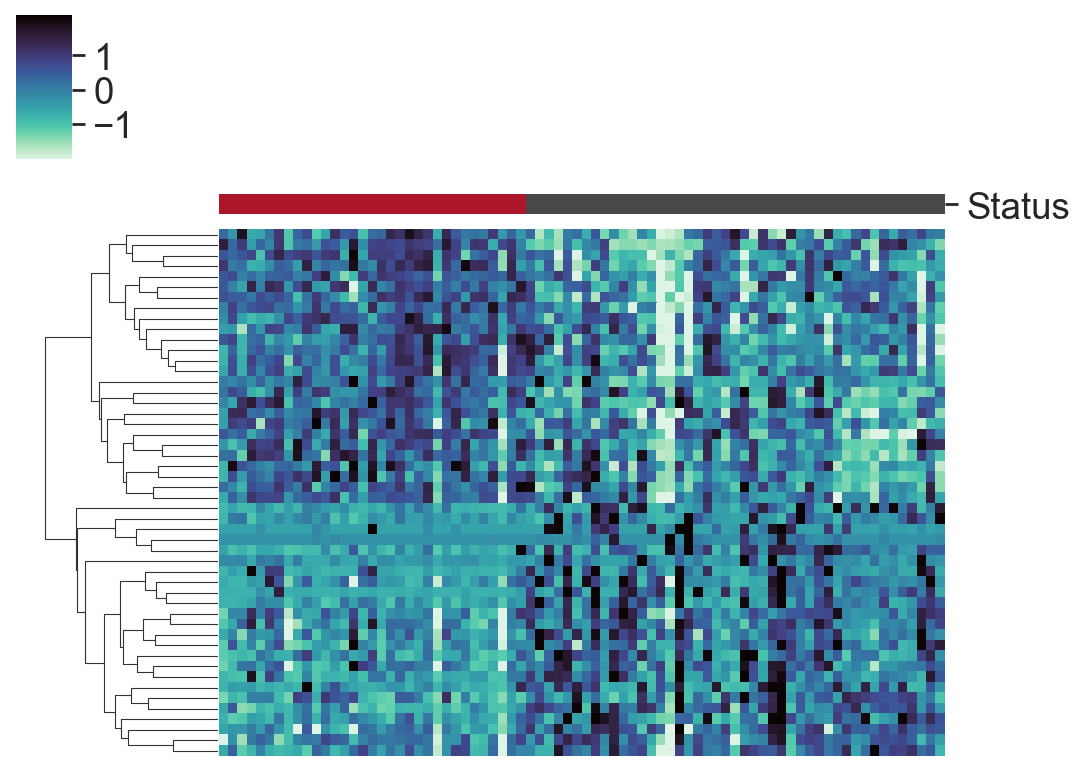

In [211]:
Heatmap(phgg, emtDE, phggDict, '', '', 1.5, (7,5), 
       pal=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]],
      colormap='mako_r', geneCluster=True, vMinMax=(None,None), ticks=[-1,0,1])

## Figure 1C

[('H3K27M', 'nonH3K27M')]


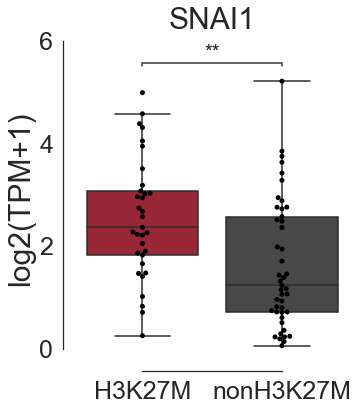

In [125]:
Boxplot(phgg, 'SNAI1', phggDict, 'SNAI1', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5, statLoc='inside' )

[('H3K27M', 'nonH3K27M')]


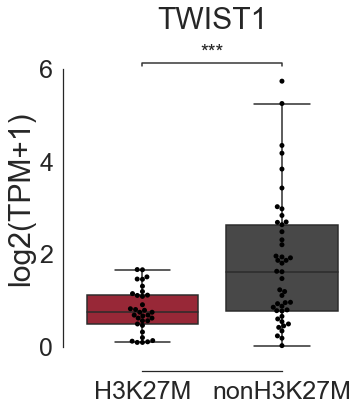

In [126]:
Boxplot(phgg, 'TWIST1', phggDict, 'TWIST1', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5, statLoc='inside' )

[('H3K27M', 'nonH3K27M')]


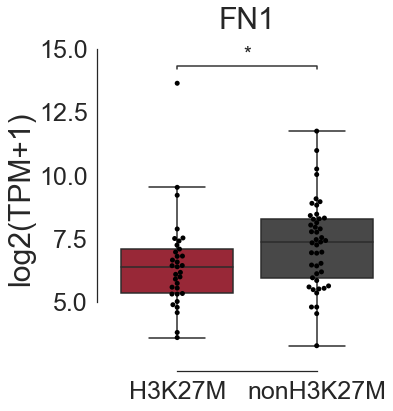

In [127]:
Boxplot(phgg, 'FN1', phggDict, 'FN1', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5, statLoc='inside' )

[('H3K27M', 'nonH3K27M')]


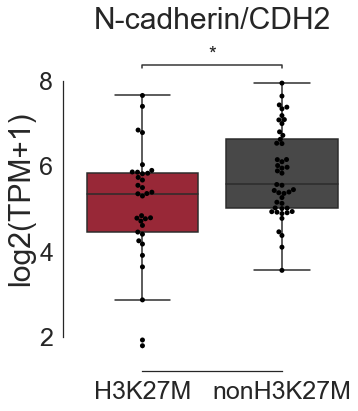

In [128]:
Boxplot(phgg, 'CDH2', phggDict, 'N-cadherin/CDH2', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5, statLoc='inside' )

[('H3K27M', 'nonH3K27M')]


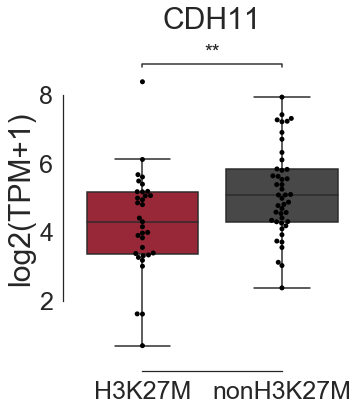

In [129]:
Boxplot(phgg, 'CDH11', phggDict, 'CDH11', 'log2(TPM+1)', '', (5,6),
        color=[sns.color_palette('RdGy', 10)[0],sns.color_palette('RdGy', 10)[9]], swarmSize=5, statLoc='inside' )

# Figure 2

## Figure 2A

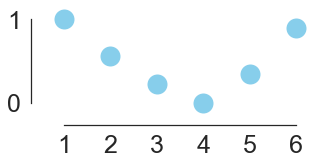

In [130]:
Swarmplot(bulkNorm, 'SNAI1', bulkDict, '', dotColor='skyblue')

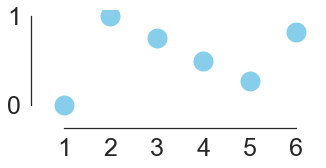

In [131]:
Swarmplot(bulkNorm, 'TWIST1', bulkDict, '', dotColor='skyblue')

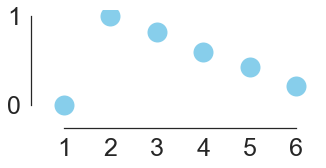

In [132]:
Swarmplot(bulkNorm, 'CDH2', bulkDict, '', dotColor='skyblue')

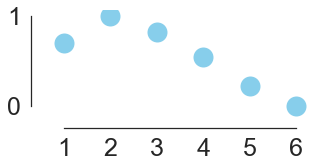

In [133]:
Swarmplot(bulkNorm, 'FN1', bulkDict, '', dotColor='skyblue')

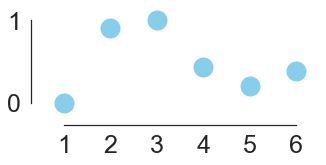

In [134]:
Swarmplot(bulkNorm, 'CDH11', bulkDict, '', dotColor='skyblue')

## Figure 2C

In [135]:
# Score organoid cells by a list of EMT completness genes
scOrgScores = scoreCells(scOrgFil, emtCom)
scOrgScores.shape

(1, 7650)

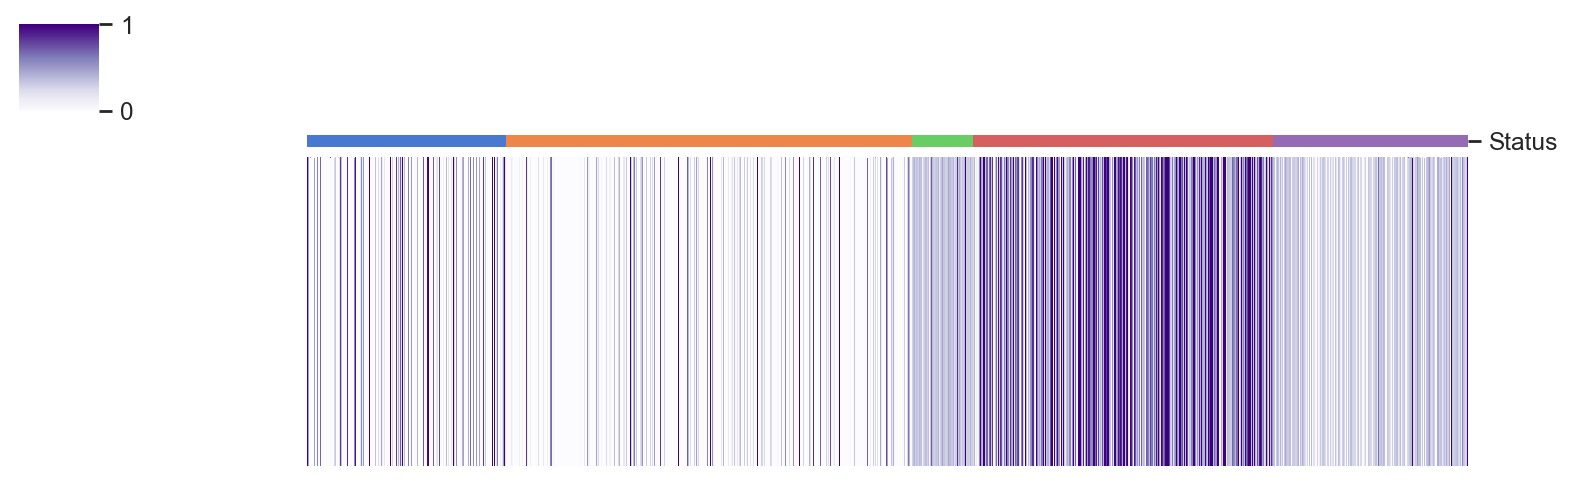

In [212]:
Heatmap(scOrgScores, [0], scOrgDict, '', 'figures/Figure2C-2.png', 1, (10,3),
       pal=sns.color_palette('muted'), colormap='Purples', geneCluster=False, vMinMax=(0,1), ticks=[0,1])

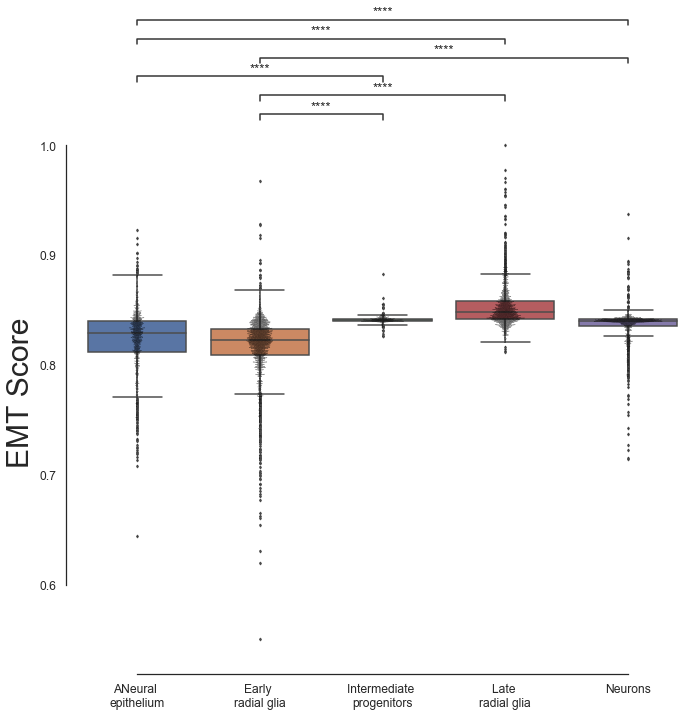

In [137]:
sns.set_palette(sns.color_palette('muted'))
sns.set(style="white", font_scale=1.1)
fig, ax = plt.subplots(figsize=(11,10))
df = scOrgScores
dictionary = scOrgDict
geneName = 0
status = []
values = []

# Subset the expression df by gene and dictionary samples 
dfSub = df.loc[[geneName]][list(dictionary.keys())]

# Expression values to plot
values = dfSub.loc[geneName].values.tolist()

# Sample status for plotting 
for name in list(dfSub.columns.values):
    if name in dictionary.keys():
        status.append(dictionary[name])

plot_df = pd.DataFrame({'Status': status,'Value': values}, columns = ['Status','Value']).sort_values(by=['Status'])

# Plot boxplot and swarmplot
ax = sns.boxplot(ax=ax, x="Status", y="Value", hue="Status", data=plot_df, dodge=False, fliersize=2)#.set_title(title)
ax = sns.swarmplot(x="Status", y="Value", color="black", data=plot_df, size=0.6)

# Add statistical annotations
add_stat_annotation(ax, data=plot_df, x="Status", y="Value", order=list(sorted(plot_df['Status'].unique())),
                box_pairs=[('Early \nradial glia','Intermediate \nprogenitors'),
                                                      ('Early \nradial glia','Late \nradial glia'),
                                                      ('Early \nradial glia','Neurons'),
                                                      ('ANeural \nepithelium','Intermediate \nprogenitors'),
                                                      ('ANeural \nepithelium','Late \nradial glia'),
                                                      ('ANeural \nepithelium','Neurons')], 
                test='Mann-Whitney', text_format='star', loc='outside', verbose=0,
                line_offset_to_box=0.05, line_offset=0.001, line_height=0.01, text_offset=1)  


sns.despine(offset=10, trim=True)
ax.legend_.remove()
ax.set_ylabel('EMT Score', fontsize=30)
ax.set_xlabel('')
ax.set_title('',fontsize=30)

plt.savefig('figures/Figure2C-1.png',dpi=500,bbox_inches='tight')

## Figure 2D

{'ANeural \nepithelium': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), 'Early \nradial glia': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), 'Intermediate \nprogenitors': (0.41568627450980394, 0.8, 0.39215686274509803), 'Late \nradial glia': (0.8392156862745098, 0.37254901960784315, 0.37254901960784315), 'Neurons': (0.5843137254901961, 0.4235294117647059, 0.7058823529411765)}


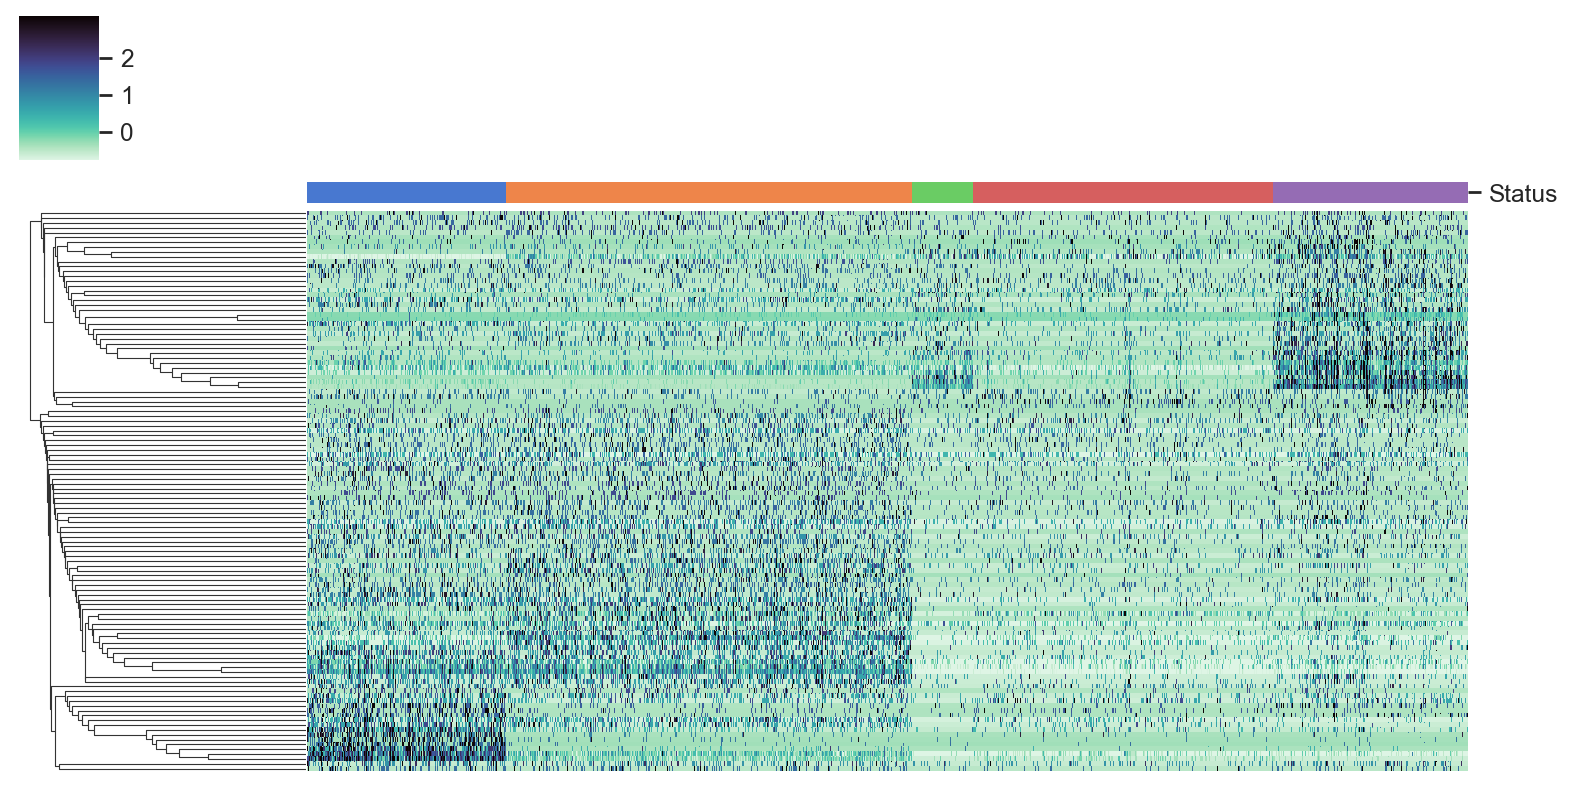

In [209]:
Heatmap(scOrgFil, list(scOrgFil.loc[scOrgFil.index.intersection(k27mUp)].index), 
        scOrgDict, '', '', 1, (10,5),
        pal=sns.color_palette('muted'), colormap='mako_r', geneCluster=True, vMinMax=(None,None), ticks=[0,1,2])

## Figure 2E

In [139]:
# Read Data
adata = sc.read('files/organoid_raw_wk2wk5.h5ad')
print(adata.shape)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(7650, 59042)


In [140]:
#### PARAMETERS FOR GATING CELLS #####
thrsh_mito=0.2
up_thrsh_genes=6000
low_thrsh_genes=50
print("Will filter out cells with more than",thrsh_mito,"percent of mitochondrial genes")
print("Will filter out cells with less than", low_thrsh_genes, "and more than", up_thrsh_genes, "genes")

#Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
#Computing percentage of mitochondrial genes
mito_genes = [name for name in adata.var_names if name.startswith('MT.') or name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = np.sum(adata.X, axis=1)

#Filtering out cells according to filter parameters
print('Scanpy: Filtering cells')
adata = adata[adata.obs['n_genes'] < up_thrsh_genes, :]
adata = adata[adata.obs['n_genes'] > low_thrsh_genes, :]
adata = adata[adata.obs['percent_mito'] < thrsh_mito, :]

#Get logarithmirized raw gene exression
adata_raw = sc.pp.log1p(adata, copy=True)
adata.raw = adata_raw

#Per-cell normalization step, Identification of highly variable genes and filtering
#Normalize using 10000 as a factor
print('Scanpy: Normalization step')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

#Finding variable genes & filtering out others
print('Scanpy: finding highly variable genes')
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
#fig=sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result.gene_subset]

#Log data
sc.pp.log1p(adata)

#Regress out variables nUMI and percent_mito, you can add 'batch' for BATCH CORRECTION (not useful here)
print('Scanpy: Regressing out variables')
sc.pp.regress_out(adata, ['n_counts','percent_mito'])

#Print number of highly variable genes
print('Number of variable genes identified:', adata.shape[1])

sc.pp.scale(adata, max_value=10)

Will filter out cells with more than 0.2 percent of mitochondrial genes
Will filter out cells with less than 50 and more than 6000 genes


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Scanpy: Filtering cells
Scanpy: Normalization step
Scanpy: finding highly variable genes


/Users/lmsh/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Scanpy: Regressing out variables
Number of variable genes identified: 4623


In [141]:
# Load cell types and DE gene list
meta_cells = pd.read_csv('files/celltypes_wk2wk5_names.csv', sep=',', index_col=0)
common_names = list(set(adata.obs.index.tolist()).intersection(set(meta_cells.index.tolist())))
mask_out = np.isin(adata.obs.index.tolist(), common_names)
meta_cells = meta_cells[np.isin(meta_cells.index.tolist(), common_names)]
adata = adata[mask_out,:].copy()
meta_cells = meta_cells.reindex(adata.obs.index.tolist())
#adata.obs['cell_type'] = [' '.join(i.split(' ')[1:]) for i in meta_cells['cell_type'].tolist()]
adata.obs['cell_type'] = meta_cells['cell_type'].tolist()

In [142]:
# Read files
gene_list= []
with open('files/DE.UpinK.inOrganoids.041920.txt') as file:
    lines = file.readlines()
    for line in lines:
        line = line.strip()
        if 'limma' not in line:
            gene_list.append(line)
file.close()

In [143]:
# DEG for cell types and rank analysis

# Run scanpy DEG with t-test overestim var
sc.tl.rank_genes_groups(adata, groupby='cell_type', n_genes=len(adata.raw.var), method='t-test_overestim_var')
ranked_genes = ct.wrangle_ranks_from_anndata(adata)


dict_cell_data = {}
cell_types = np.unique(adata.obs['cell_type'])
# Loop over cell types to get ranks
for cell in cell_types:
    data = ranked_genes[ranked_genes['cluster_number']==cell]
    # Get median
    ranks = [data[data['gene']==lnc].index[0] for lnc in set(gene_list).intersection(set(data['gene']))]
    ranks = ((len(data))-np.array(ranks))/(len(data))
    dict_cell_data[cell] = ranks

# Plot with seaborn
res_df = pd.DataFrame(dict_cell_data)
res_df = res_df.rename(columns={'Neuroepithelium':'Neural\nepithelium',
                             'Early radial glia':'Early\nradial\nGlia',
                            'Intermediate Progenitors':'Intermediate\nprogenitors',
                            'Late radial glia':'Late\nradial\nGlia',
                            'Neurons':'Neurons'})

... storing 'cell_type' as categorical


Wrangling: Number of markers used in ranked_gene_groups:  31671
Wrangling: Groups used for ranking: cell_type


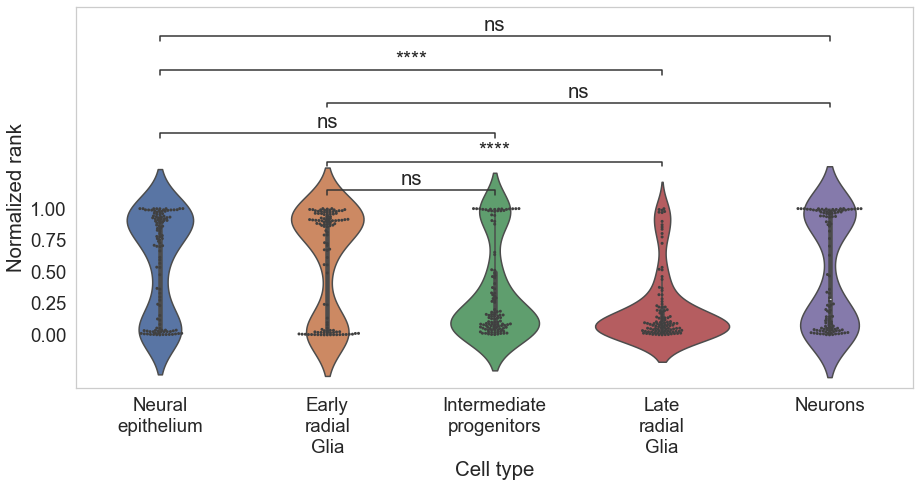

In [144]:
ordered_labels = ['Neural\nepithelium','Early\nradial\nGlia', 'Intermediate\nprogenitors', 'Late\nradial\nGlia', 'Neurons']
res_df = res_df.reindex(columns=ordered_labels)
sns.set(font_scale=1.7)
sns.set_style("whitegrid", {'axes.grid' : False})
#res_df.rename(columns={ct:'\n'.join(ct.split(' ')) if '-' not in ct else '\n'.join(ct.split('-')) for ct in ordered_labels}, inplace=True)
fig = plt.figure(figsize=[15,7])
ax = sns.violinplot(data=res_df, boxprops=dict(alpha=.5), showfliers=False)
ax = sns.swarmplot(data=res_df, color='.25', size=3)

add_stat_annotation(ax, data=res_df, box_pairs=[('Early\nradial\nGlia','Intermediate\nprogenitors'),
                                                          ('Early\nradial\nGlia','Late\nradial\nGlia'),
                                                          ('Early\nradial\nGlia','Neurons'),
                                                          ('Neural\nepithelium','Intermediate\nprogenitors'),
                                                          ('Neural\nepithelium','Late\nradial\nGlia'),
                                                          ('Neural\nepithelium','Neurons')],
                                  test='Mann-Whitney', text_format='star', loc='inside', verbose=0)

ax.set_ylabel('Normalized rank')
ax.set_xlabel('Cell type')
ax.set_yticks(ticks=np.linspace(0,1, 5))
plt.savefig('figures/Figure2E.png', format='png', dpi=600, bbox_inches = "tight")

# Figure 3

## Figure 3A


### Dendrogram
Cluster the scGlioma RNA seq samples by expression of EMT genes.

Inspired by Valentine Svensson's work "Extract Cluster Elements by Color in Python Dendrograms", 2014 nxn.se/valent/

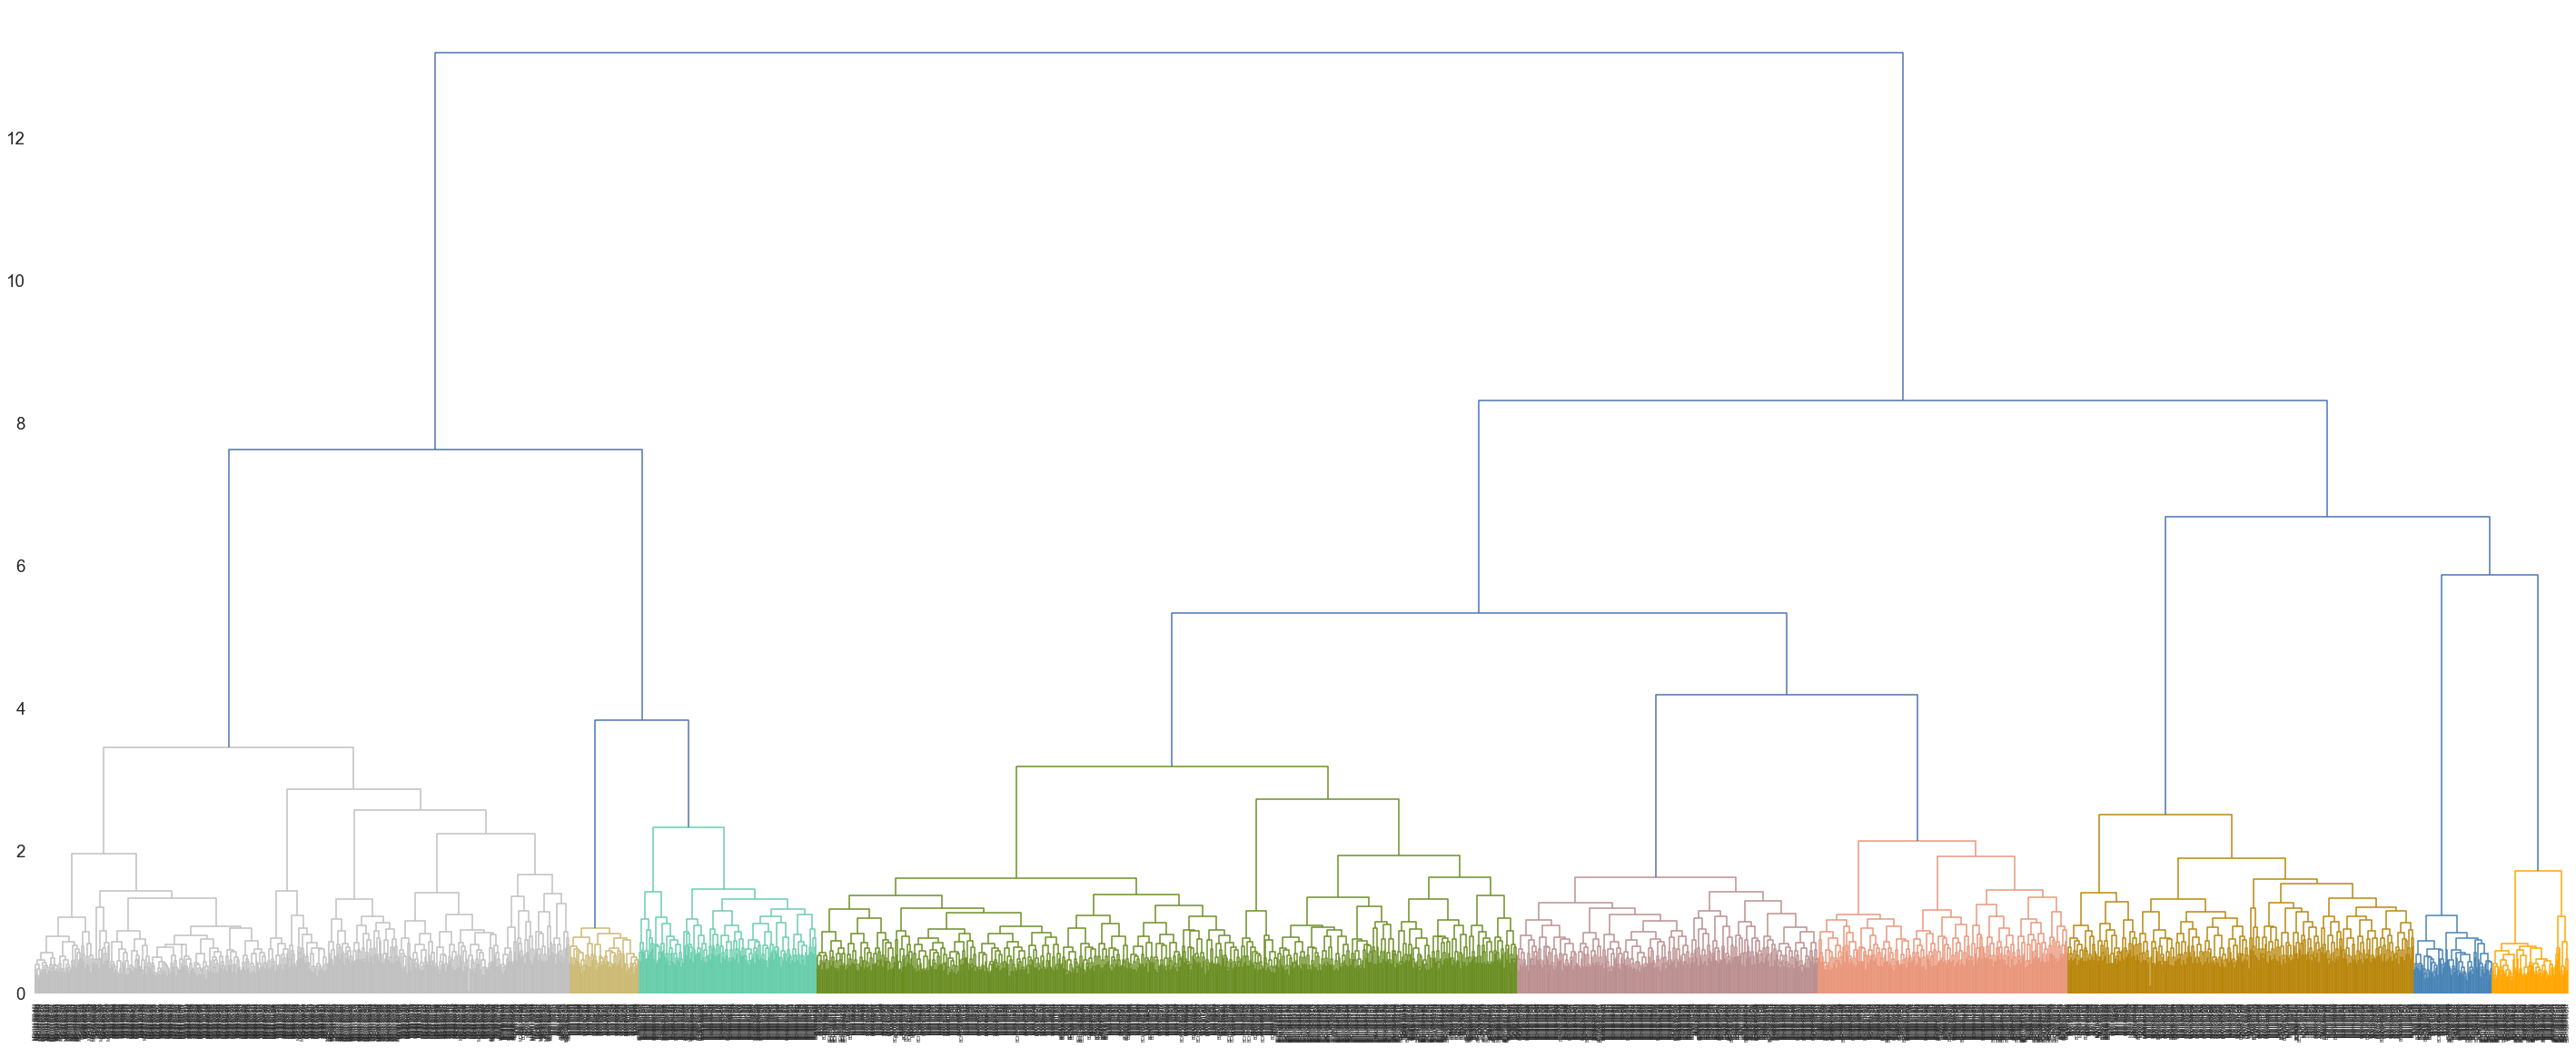

In [145]:
# Set colors
set_link_color_palette(['silver', 'y', 'mediumaquamarine', 'olivedrab', 'rosybrown', 'darksalmon', 'darkgoldenrod', 'steelblue', 'orange', 'mediumpurple'])
sns.set_style('white')

# Calculate linkages
link = linkage(scGlioma.loc[scGlioma.index.intersection(emtMaster)].transpose(), metric='correlation', method='ward')

# Plot dendrogram 
figure(figsize=(50,20), facecolor='w')
dendr = dendrogram(link, labels=scGlioma.transpose().index, color_threshold=3.5) 
plt.xticks(rotation=90)
no_spine = {'left': True, 'bottom': True, 'right': True, 'top': True}
sns.despine(**no_spine);


In [146]:
# Get cluster assignments from dendrogram
clusterIndex = defaultdict(list)
for c, pi in zip(dendr['color_list'], dendr['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            clusterIndex[c].append(int(i))
            
allClusters = [] 
for c, l in clusterIndex.items():
    i_l = [dendr['ivl'][i] for i in l]
    allClusters.append(i_l)

len(allClusters)


9

In [147]:
# Dictionary relating cluster name and sample
dendrDict = {}
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
i = 0
for cluster in allClusters:
    for sample in cluster:
        dendrDict[sample] = alphabet[i]
    i += 1


### Cluster expression signatures 
For all genes in the EMT master list that passed the scGlioma RNA seq filter, assign each gene to a cluster based on maximum mean expression.

In [148]:
clusterNames = ['A','B','C','D','E','F','G','H','I','J']
geneClusterDict = {} 
for gene in scGlioma.loc[scGlioma.index.intersection(emtMaster)].index: 
    meanGene = [] 
    
    # get mean gene exp for each cluster
    for clust in clusterNames: 
        meanGene.append(np.mean(list(scGlioma[[x for x in dendrDict if dendrDict[x] == clust]].loc[gene]))) 
        
    # find cluster with max expression for that gene
    maxCluster = clusterNames[meanGene.index(max(meanGene))]  
    
    # dictionary relating cluster assignment for each gene
    geneClusterDict[gene] = maxCluster        


/Users/lmsh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  for extra precision.
/Users/lmsh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  if isinstance(ret, mu.ndarray):


In [149]:
# Get gene list ordered by cluster
genesOrdByCluster = []
for clust in clusterNames:
    for x in geneClusterDict:
        if geneClusterDict[x] == clust:
            genesOrdByCluster.append(x)

### Heatmap

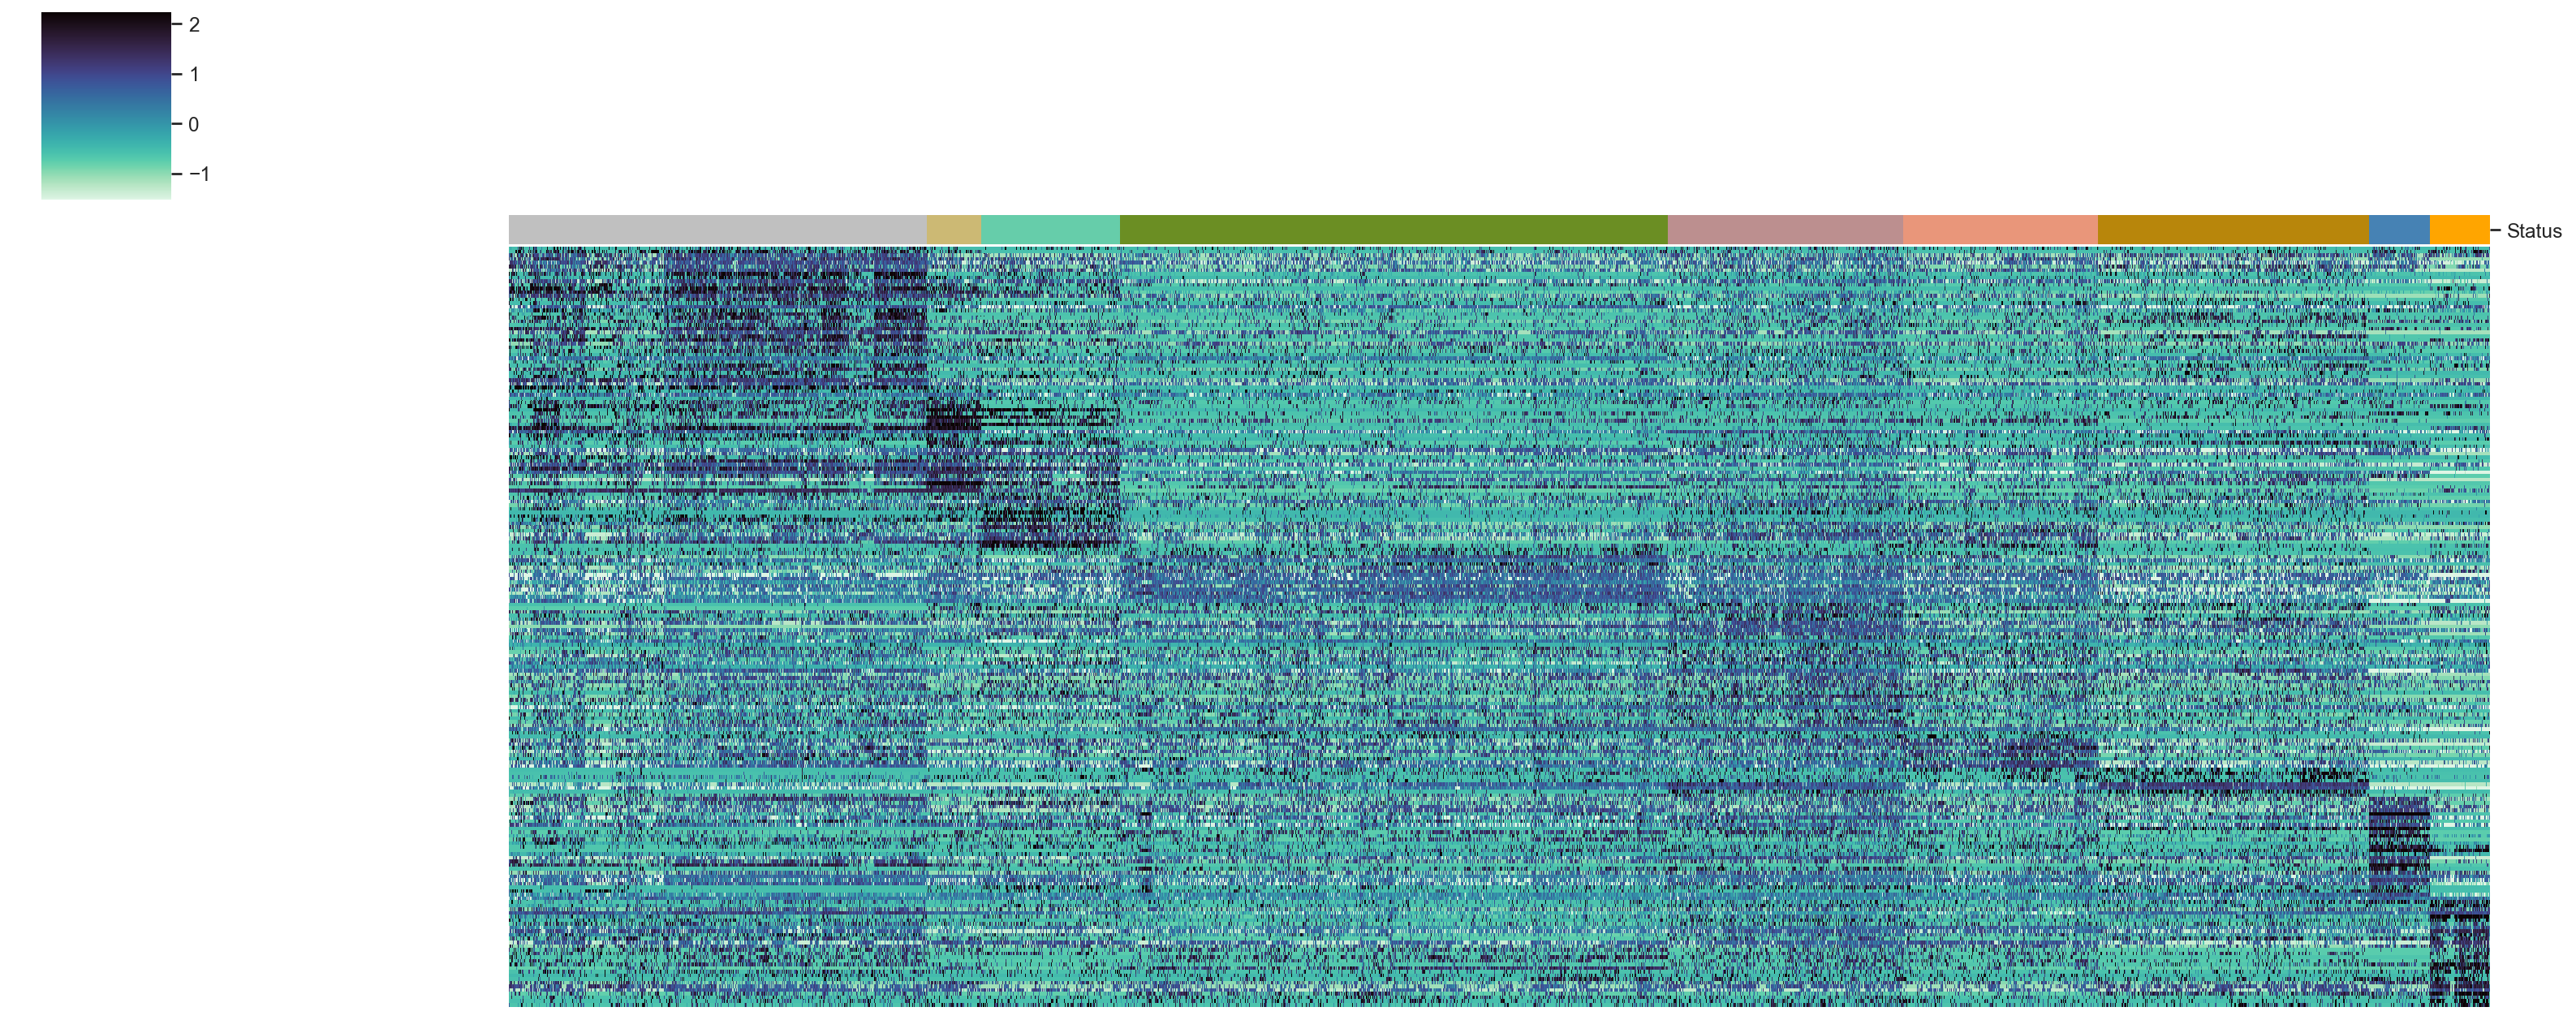

In [213]:
colors = ['silver', 'y', 'mediumaquamarine', 'olivedrab', 
          'rosybrown', 'darksalmon', 'darkgoldenrod', 'steelblue', 'orange', 'mediumpurple']

Heatmap(scGlioma, genesOrdByCluster, dendrDict, '', '', 1, (20,8), pal=colors, 
        colormap='mako_r', geneCluster=False, vMinMax=(None,None), ticks=[-1,0,1,2])

EMT score bar --- 

In [151]:
# Score glioma cells by a list of EMT completness genes
scGliScores = scoreCells(scGlioma, emtCom)
scGliScores.shape

(1, 3057)

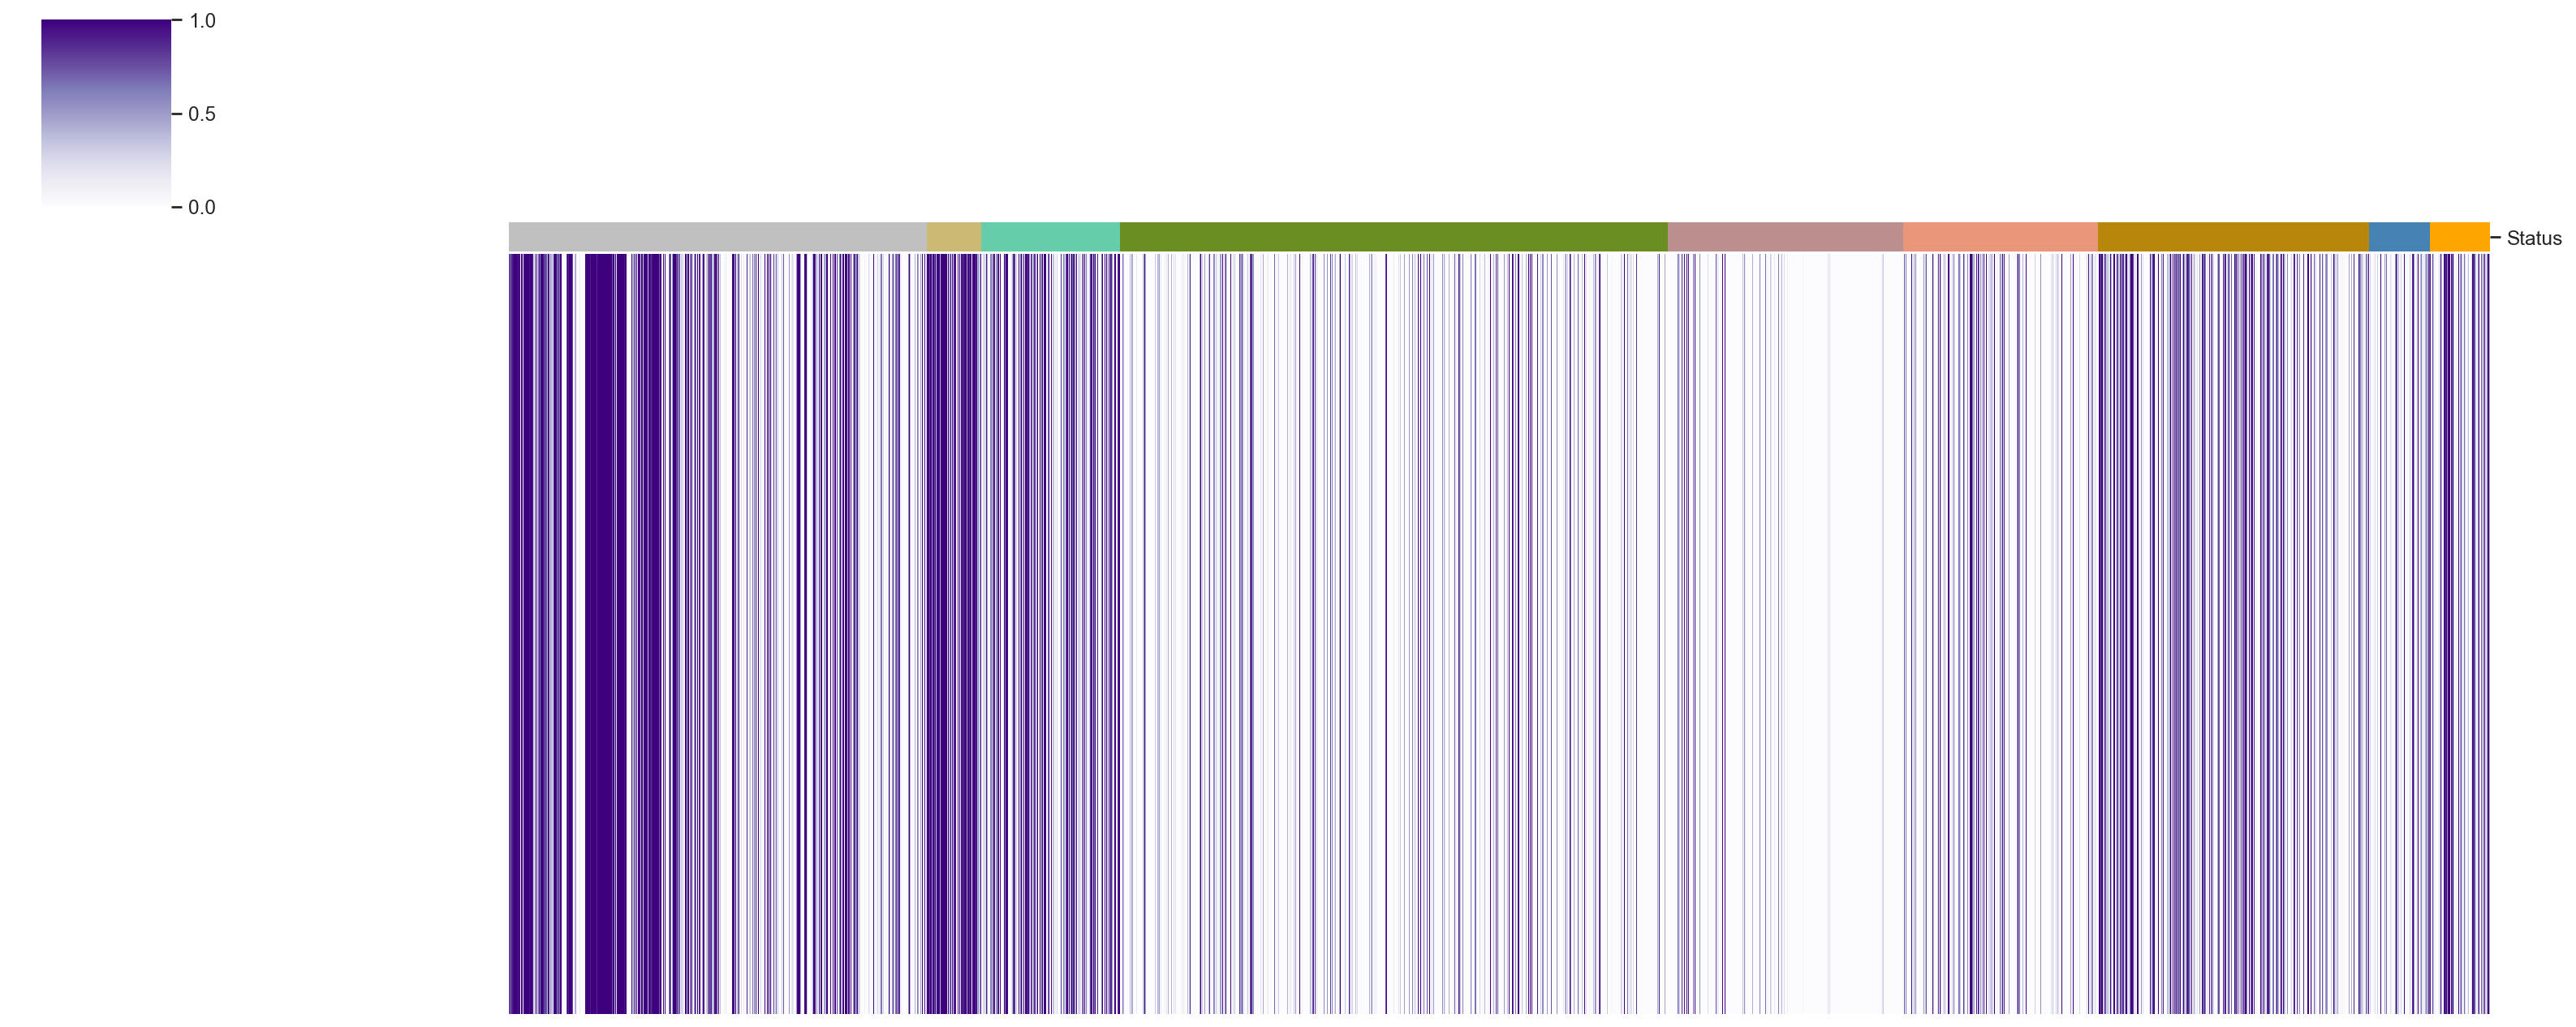

In [214]:
Heatmap(scGliScores, [0], dendrDict, '', '', 1, (20,8), pal=colors, 
        colormap='Purples', geneCluster=False, vMinMax=(0,1), ticks=[0,0.5,1])

Mutation status bar --- 

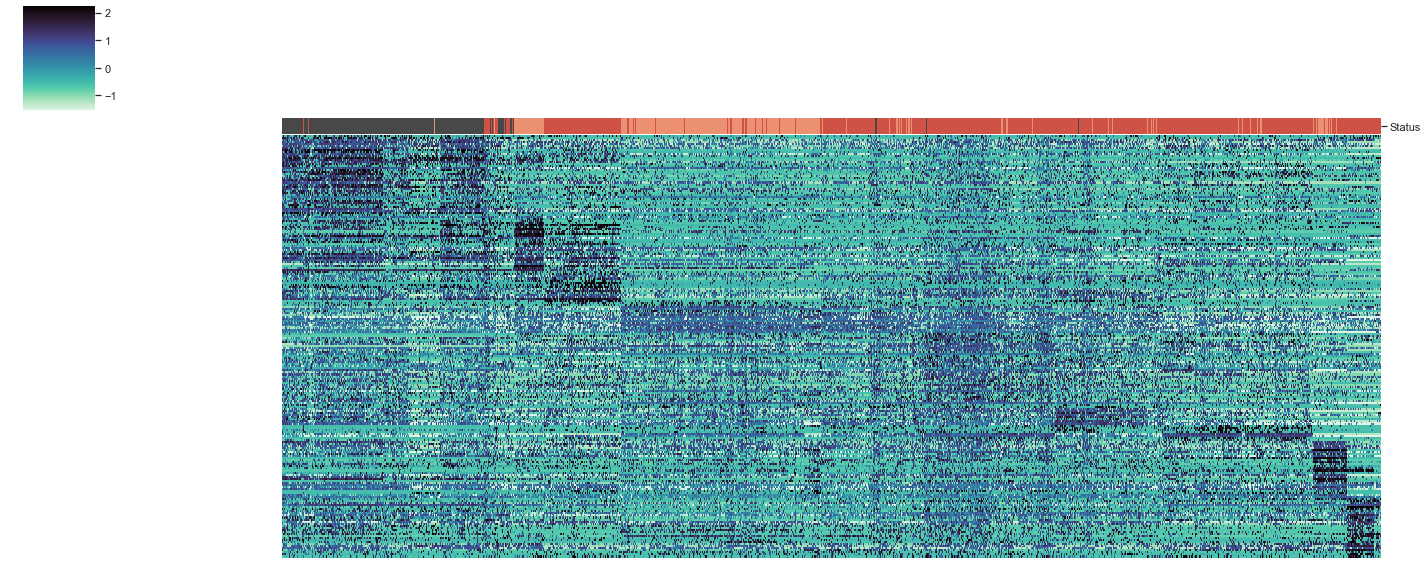

In [153]:
# subset expression to EMT genes and reorder by cluster assignment
dfSub = scGlioma.loc[scGlioma.index.intersection(genesOrdByCluster)].reindex(genesOrdByCluster)[list(dendrDict.keys())]

# Get mutation status
stat = pd.DataFrame(pd.Series(scGliomaDict))
stat.rename(columns={ stat.columns[0]: "Status" }, inplace=True)
statOnly = stat.pop('Status')

# Heatmap
pal=[sns.color_palette("RdGy", 10)[1],sns.color_palette("RdGy", 10)[2],sns.color_palette("RdGy", 10)[9]]
lut = dict(zip(statOnly.unique(), pal))
col_colors = statOnly.map(lut)    
g = sns.clustermap(dfSub, cmap='mako_r',
                    z_score=0, col_colors=col_colors, xticklabels=False, yticklabels=False,
                   metric='correlation', col_cluster=False, row_cluster=False, 
                   robust=True, square=False, figsize=(20,8))

plt.savefig('',dpi=300,bbox_inches="tight")

Patient status bar --- 

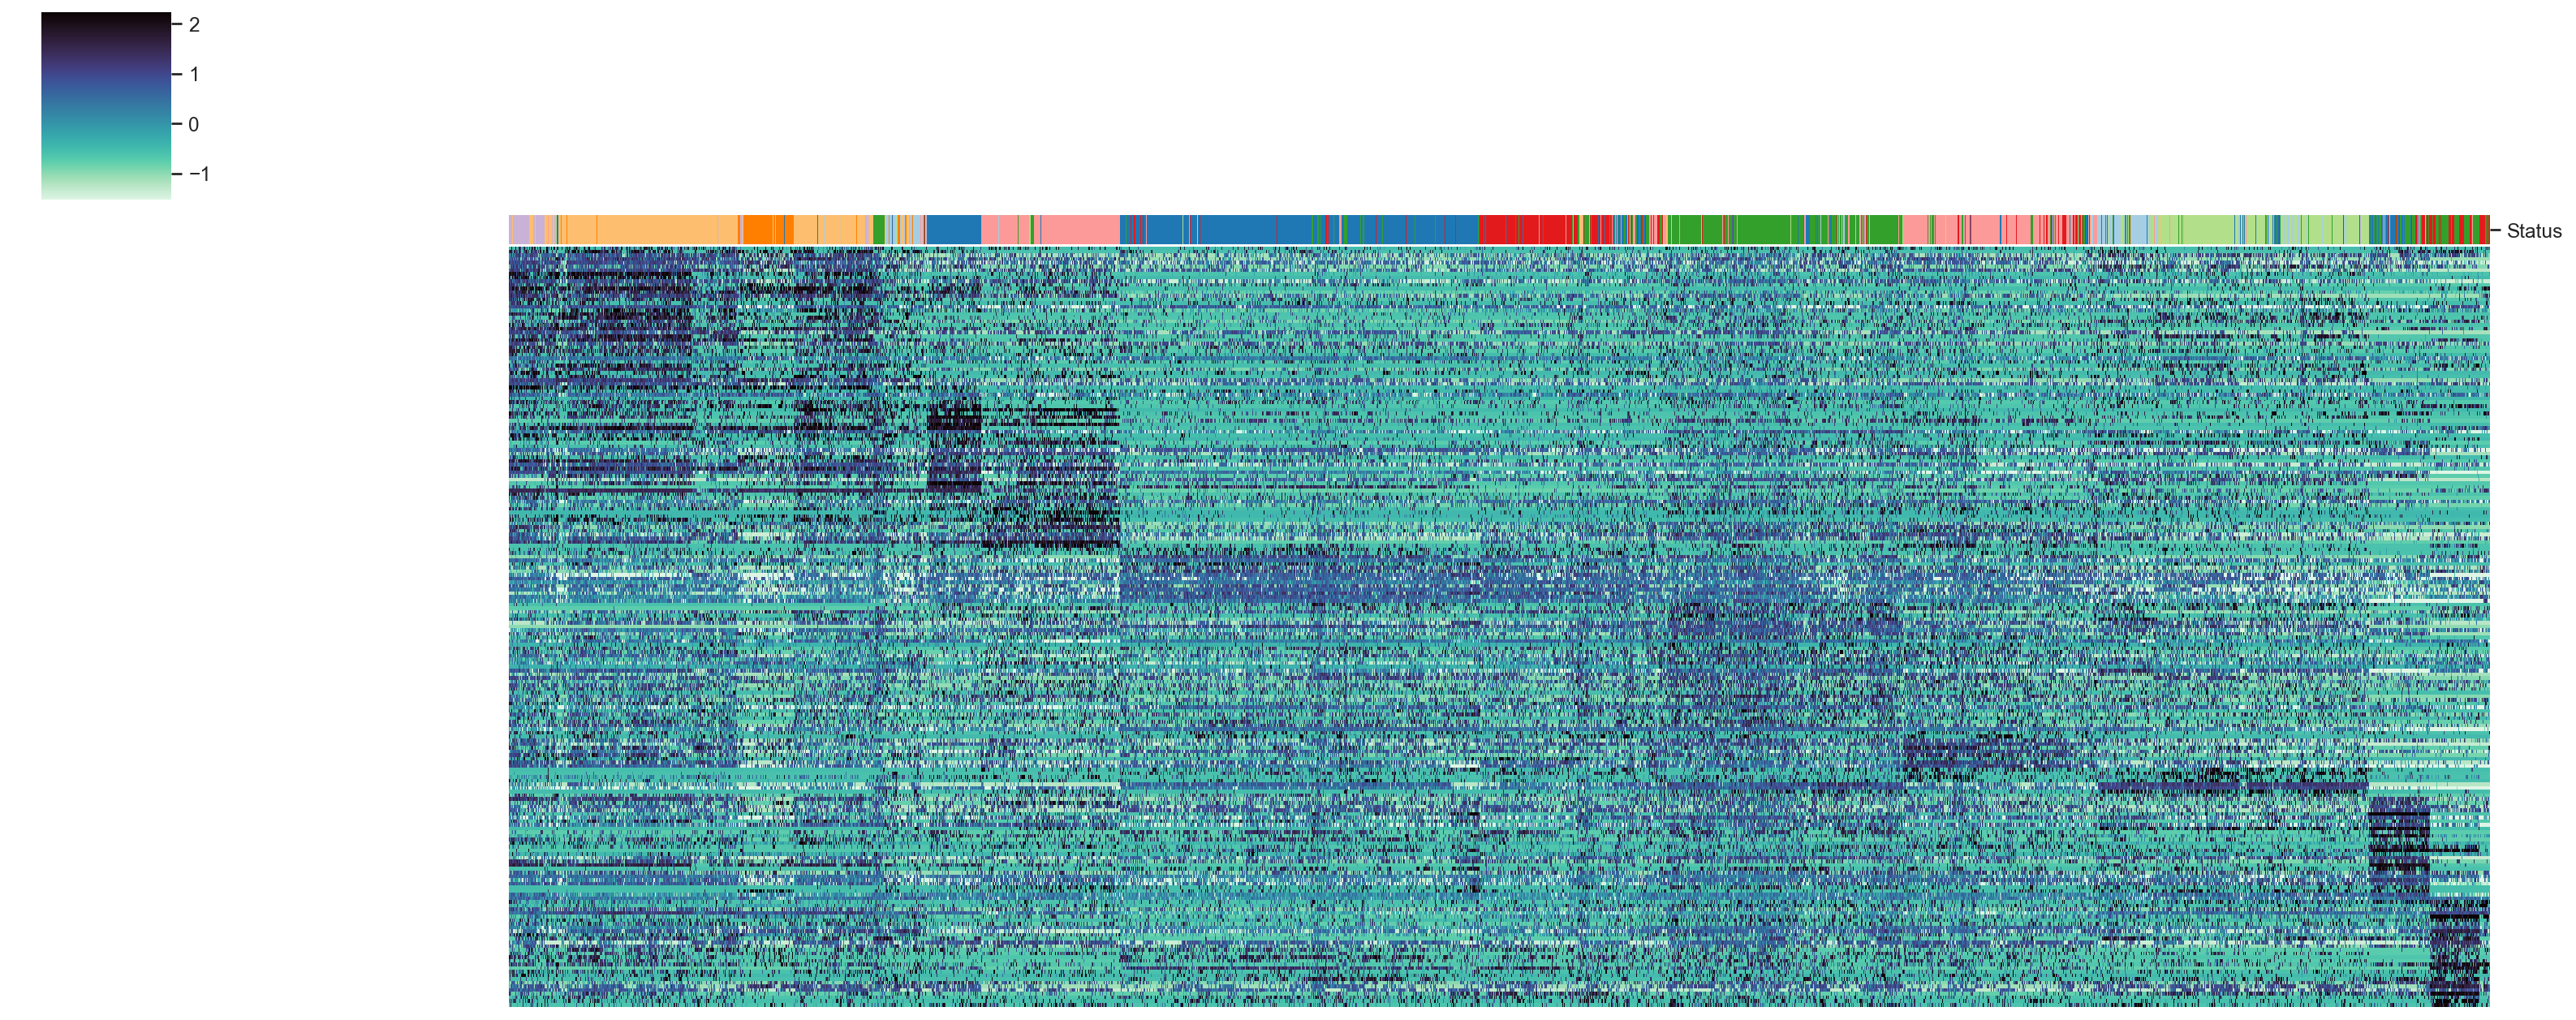

In [215]:
# subset expression to EMT genes and reorder by cluster assignment
dfSub = scGlioma.loc[scGlioma.index.intersection(genesOrdByCluster)].reindex(genesOrdByCluster)[list(dendrDict.keys())]

# Get patient status
stat = pd.DataFrame(pd.Series(scGliomaPatientDict))
stat.rename(columns={ stat.columns[0]: "Status" }, inplace=True)
statOnly = stat.pop('Status')

# Heatmap
pal=sns.color_palette('Paired')
lut = dict(zip(statOnly.unique(), pal))
col_colors = statOnly.map(lut)
g = sns.clustermap(dfSub, cmap='mako_r',
                    z_score=0, col_colors=col_colors, xticklabels=False, yticklabels=False,
                   metric='correlation', col_cluster=False, row_cluster=False, 
                   robust=True, square=False, figsize=(20,8))

plt.savefig('',dpi=300,bbox_inches="tight")

## Figure 3B

In [162]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, fontsize=28)

In [184]:
# create scanpy anndata object from glioma single cell data subset to EMT genes
annData = sc.AnnData(scGlioma.loc[scGlioma.index.intersection(emtMaster)].transpose())
annData

AnnData object with n_obs × n_vars = 3057 × 207 

In [185]:
# add cluster annotations from dictionary
annData.obs['cluster'] = pd.DataFrame(pd.Series(dendrDict)).reindex(list(annData.obs.index))[0]

In [186]:
# add mutation annotations from dictionary
annData.obs['mutation'] = pd.DataFrame(pd.Series(scGliomaDict)).reindex(list(annData.obs.index))[0]

In [187]:
# add EMT score annotations 
annData.obs['score'] = scGliScores.transpose()[0]

In [188]:
# calculate principal components and neighborhood graph clustering
sc.tl.pca(annData, svd_solver='arpack')
sc.pp.neighbors(annData, n_neighbors=10, n_pcs=10) 
sc.tl.umap(annData)
sc.tl.leiden(annData, resolution=0.5) 

... storing 'cluster' as categorical
... storing 'mutation' as categorical


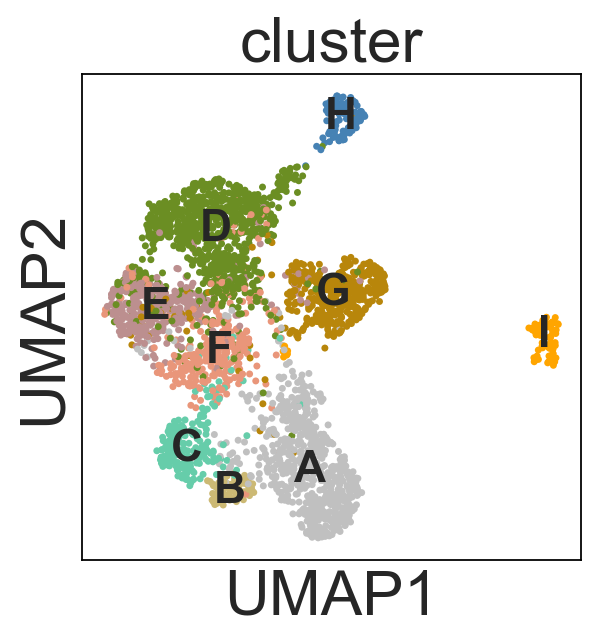

In [189]:
# Plot clusters
colors = ['silver', 'y', 'mediumaquamarine', 'olivedrab', 
          'rosybrown', 'darksalmon', 'darkgoldenrod', 'steelblue', 'orange', 'mediumpurple']

sc.pl.umap(annData, color='cluster', legend_fontsize=20, 
           palette=colors, legend_loc='on data', save='3B-cluster.png')

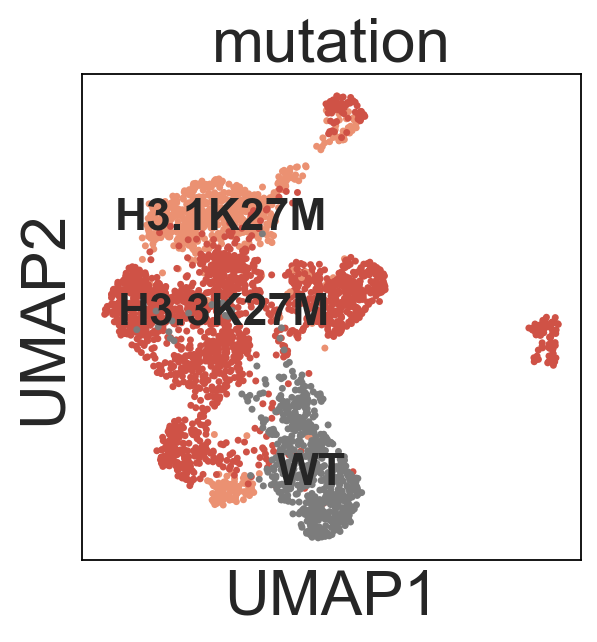

In [190]:
# Plot mutation status
mutationColors = [sns.color_palette("RdGy", 10)[2], 
                  sns.color_palette("RdGy", 10)[1], 
                  sns.color_palette("RdGy", 10)[8]]

sc.pl.umap(annData, color='mutation', palette=mutationColors, legend_fontsize=20, 
           legend_loc='on data', save='3B-mutation.png')

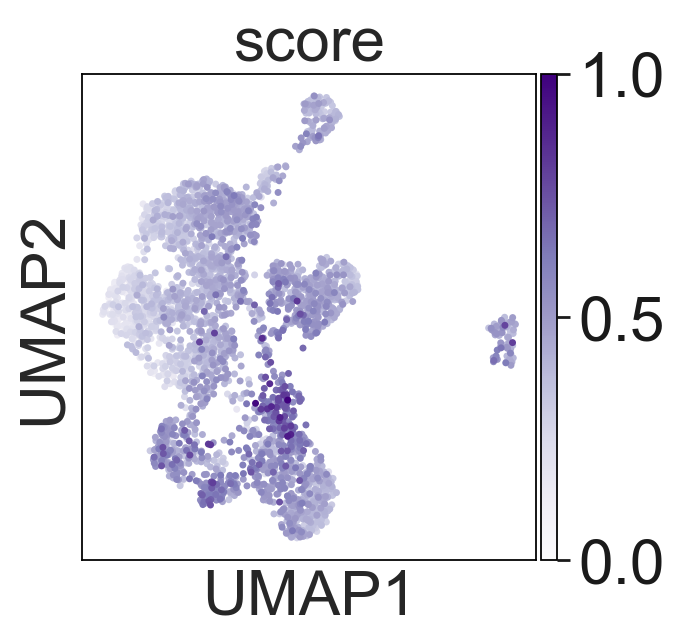

In [191]:
# Plot EMT score
sc.pl.umap(annData, color='score', legend_fontsize=20, 
           cmap='Purples', save='3B-score.png')

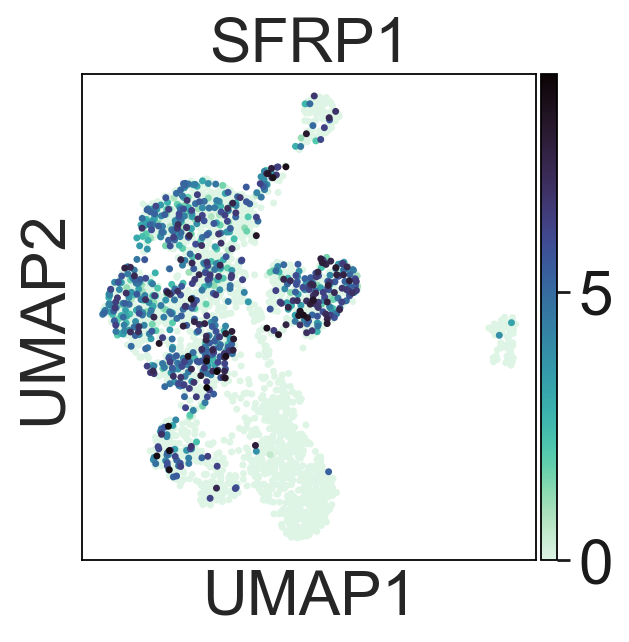

In [192]:
sc.pl.umap(annData, cmap='mako_r', color=['SFRP1'],
           save='3B-SFRP1.png')

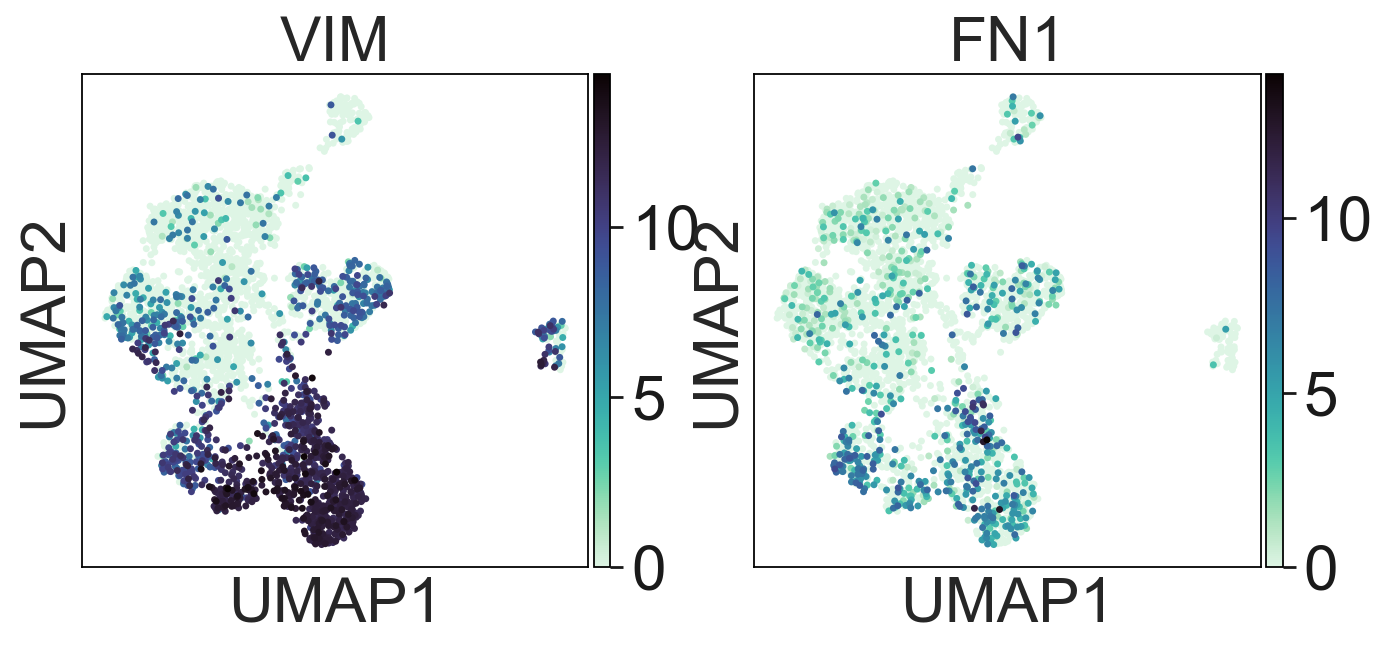

In [193]:
sc.pl.umap(annData, cmap='mako_r', color=['VIM', 'FN1'],
           save='3B-mes1.png')

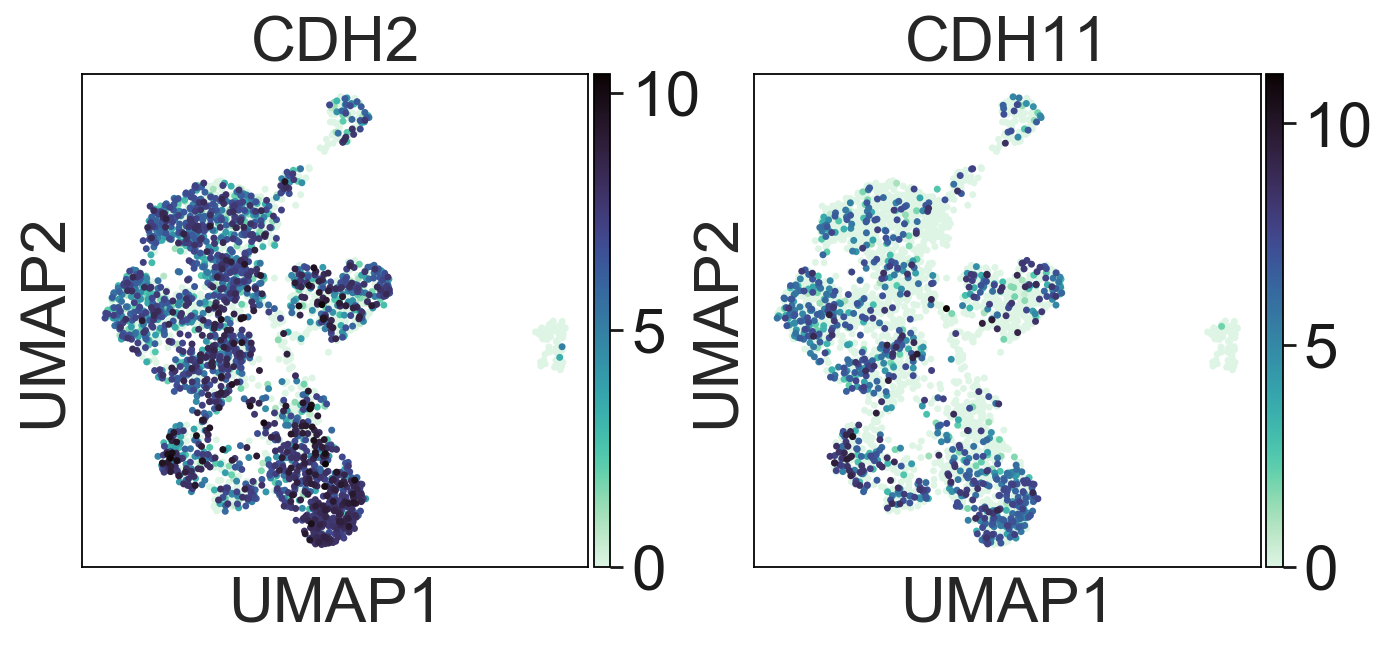

In [194]:
sc.pl.umap(annData, cmap='mako_r', color=['CDH2', 'CDH11'],
           save='3B-mes2.png')

# Figure 4

## Figure 4A

In [195]:
annData_sub = annData[annData.obs['mutation'] != 'WT',:]
annData_sub

View of AnnData object with n_obs × n_vars = 2458 × 207 
    obs: 'cluster', 'mutation', 'score', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'cluster_colors', 'mutation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Trying to set attribute `.uns` of view, copying.


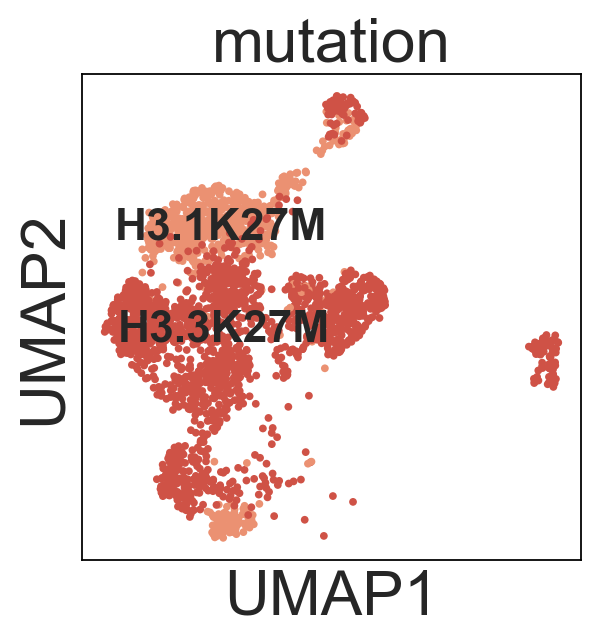

In [196]:
sc.pl.umap(annData_sub, color='mutation', palette=mutationColors, legend_fontsize=20, 
           legend_loc='on data', save='')

## Figure 4B & Figure S1

In [197]:
# Find genes significantly over expressed in the H3.3 K27M cells vs. H3.1 K27M, and vice versa
sc.tl.rank_genes_groups(annData_sub, 'mutation', method='wilcoxon')

# Write out the genes differentially expressed in each group (see Supplementary Table 4)
#pd.DataFrame(annData_sub.uns['rank_genes_groups']['names']).to_csv('filename.csv', sep=",",header=True)

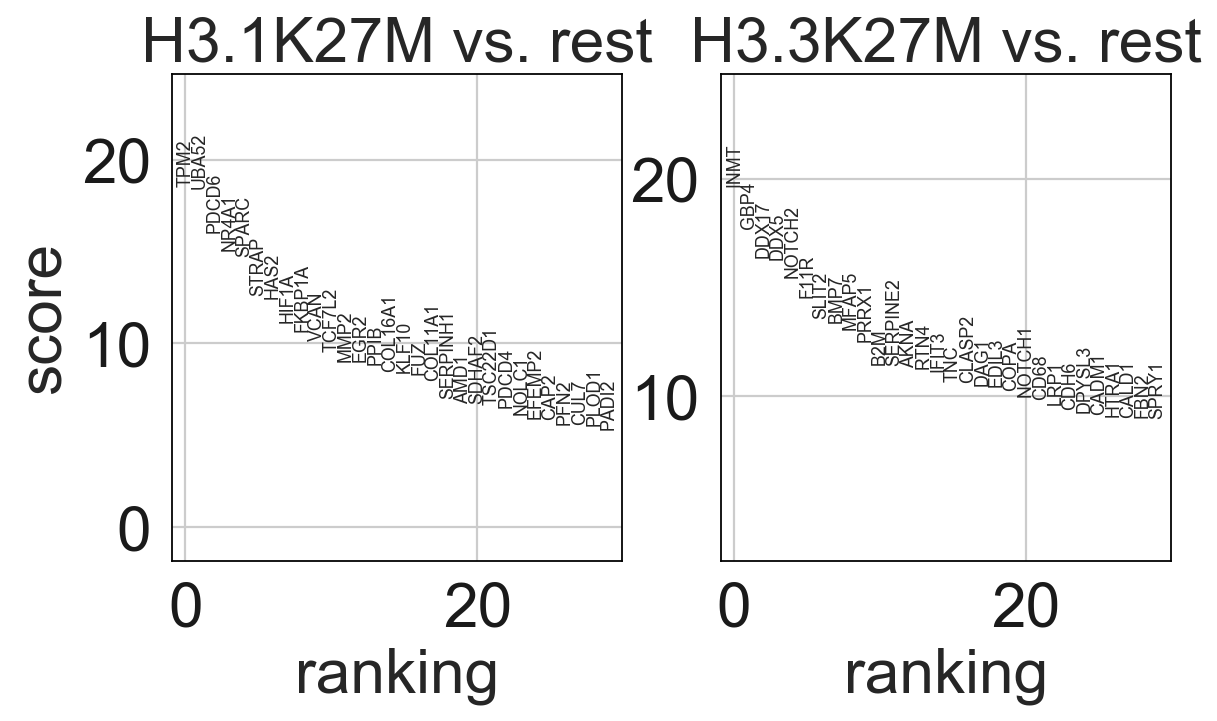

In [198]:
# Supplementary Figure 1
sc.pl.rank_genes_groups(annData_sub, n_genes=30, sharey=False, save='')


In [199]:
# pathways enriched in genes differentially expressed between H3.3 K27M and H3.1 K27M clusters 
# derived from Supplementary table 4
h33up = pd.read_csv('files/glioma.sc.H3.3overH3.1.csv',sep=',')
h31up = pd.read_csv('files/glioma.sc.H3.1overH3.3.csv',sep=',')

Figure 4B ---- 

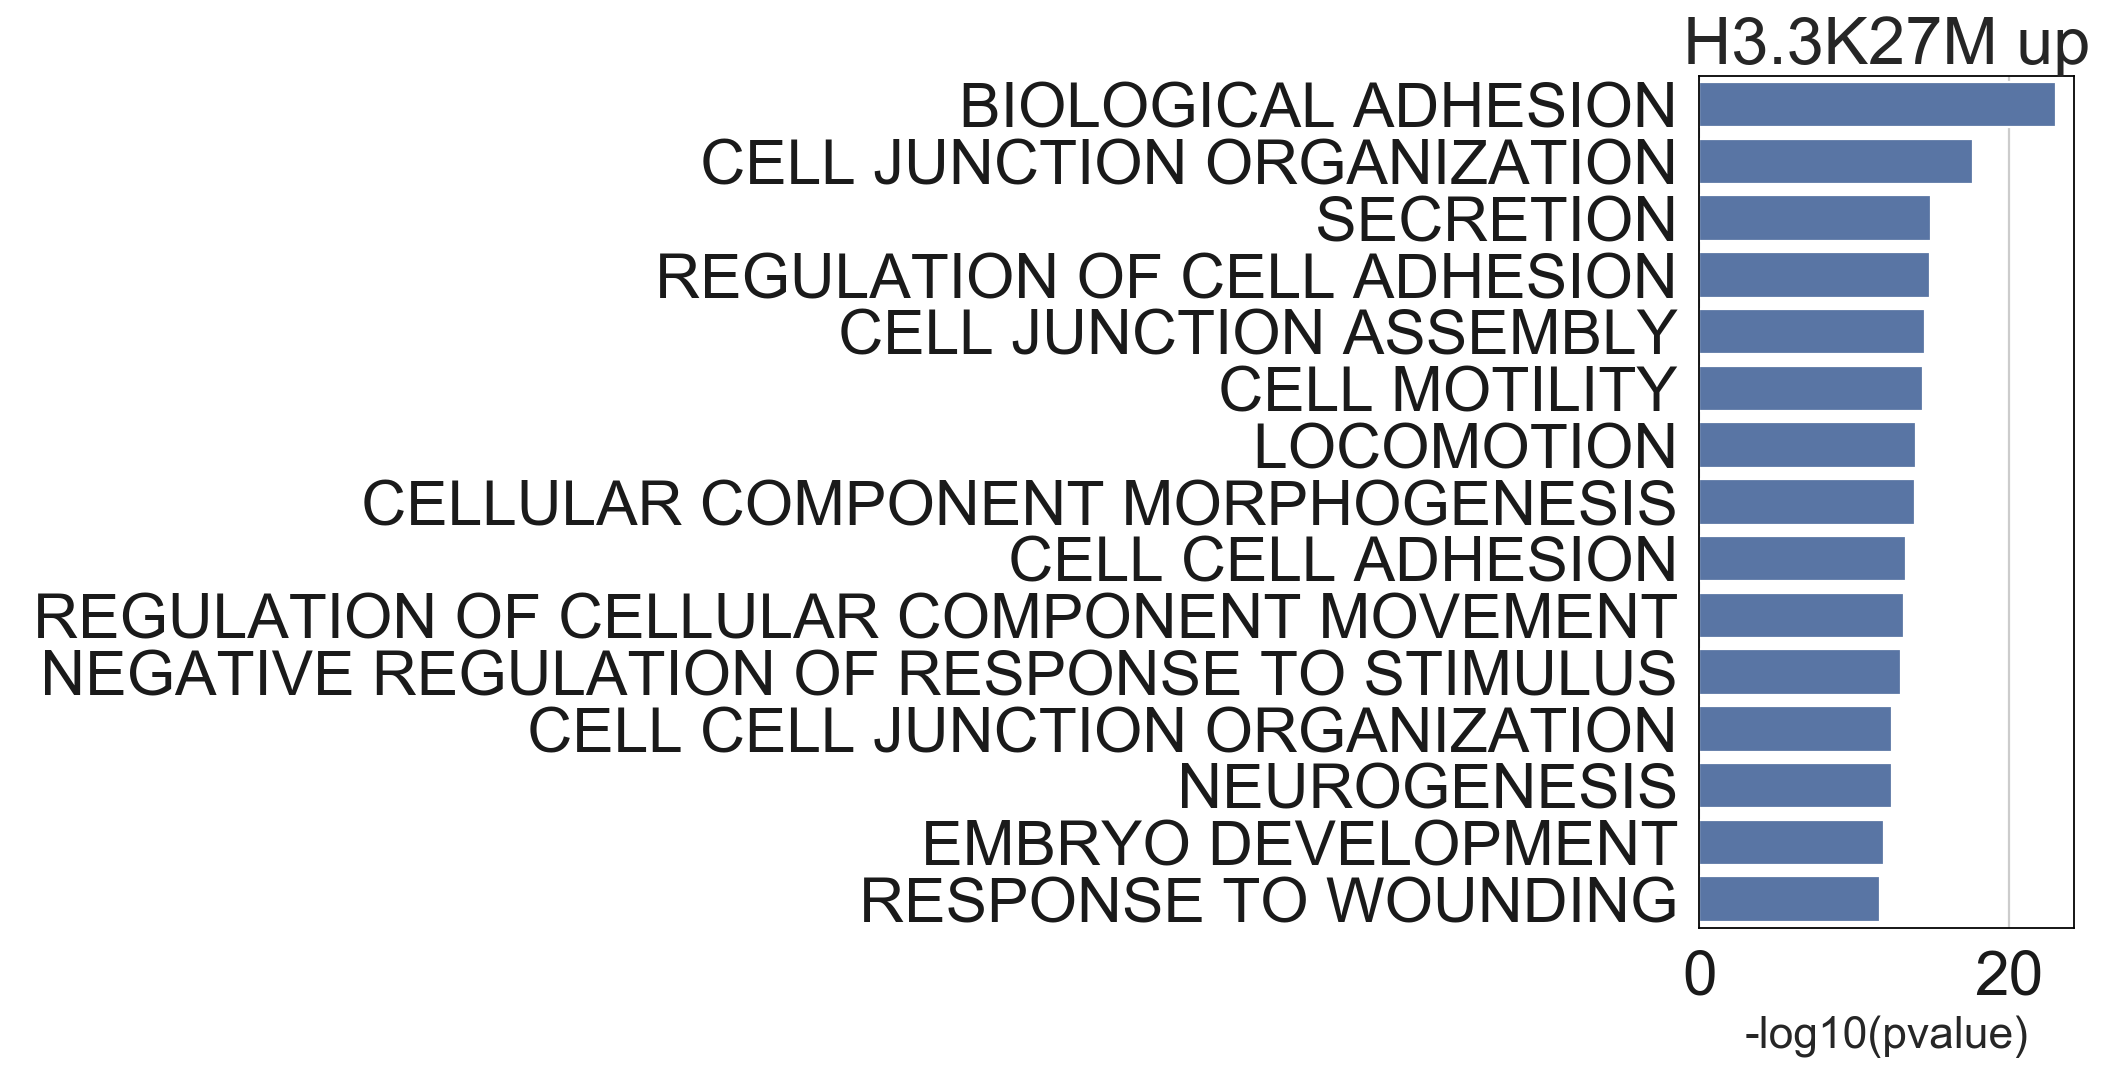

In [200]:
f, ax = plt.subplots(figsize=(3,7))
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20) 

sns.barplot(x='pvalue(-log10)', y='pathway', data=h33up, color='b')

ax.set_ylabel('')
ax.set_xlabel('-log10(pvalue)',fontsize=20)

ax.set_title('H3.3K27M up',fontsize=30)

plt.savefig('figures/4B-1.png', dpi=500, bbox_inches='tight')

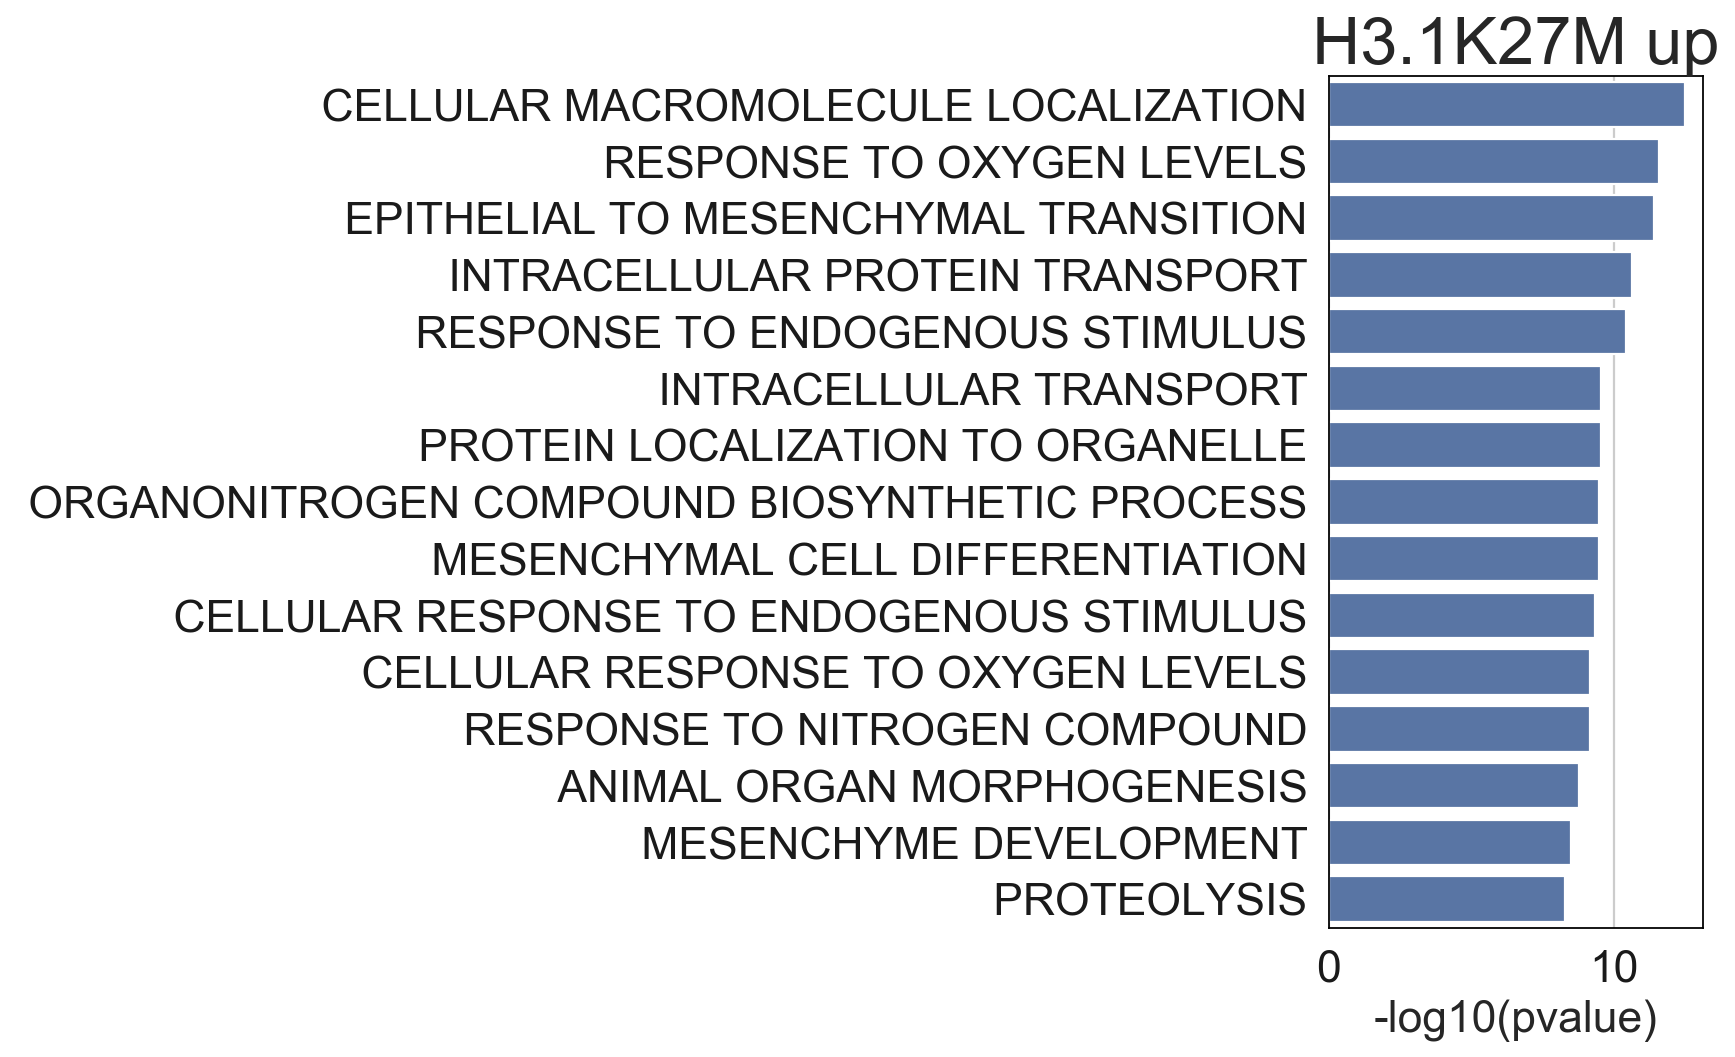

In [201]:
f, ax = plt.subplots(figsize=(3,7))
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20)  

sns.barplot(x='pvalue(-log10)', y='pathway', data=h31up, color='b')

ax.set_ylabel('')
ax.set_xlabel('-log10(pvalue)',fontsize=20)

ax.set_title('H3.1K27M up',fontsize=30)

plt.savefig('figures/4B-2.png', dpi=500, bbox_inches='tight')

## Figure 4D

In [202]:
# Score glioma cell line samples by a list of EMT completness genes
gliomaCellLineScores = scoreCells(cl, emtCom)
gliomaCellLineScores.shape

(1, 11)

In [203]:
mutationColors = [sns.color_palette("RdGy", 10)[2], 
                  sns.color_palette("RdGy", 10)[1], 
                  sns.color_palette("RdGy", 10)[8]]

{'H3.1': (0.9222606689734717, 0.5674740484429065, 0.4486735870818915), 'H3.3': (0.8115340253748559, 0.3211072664359862, 0.2758169934640523)}


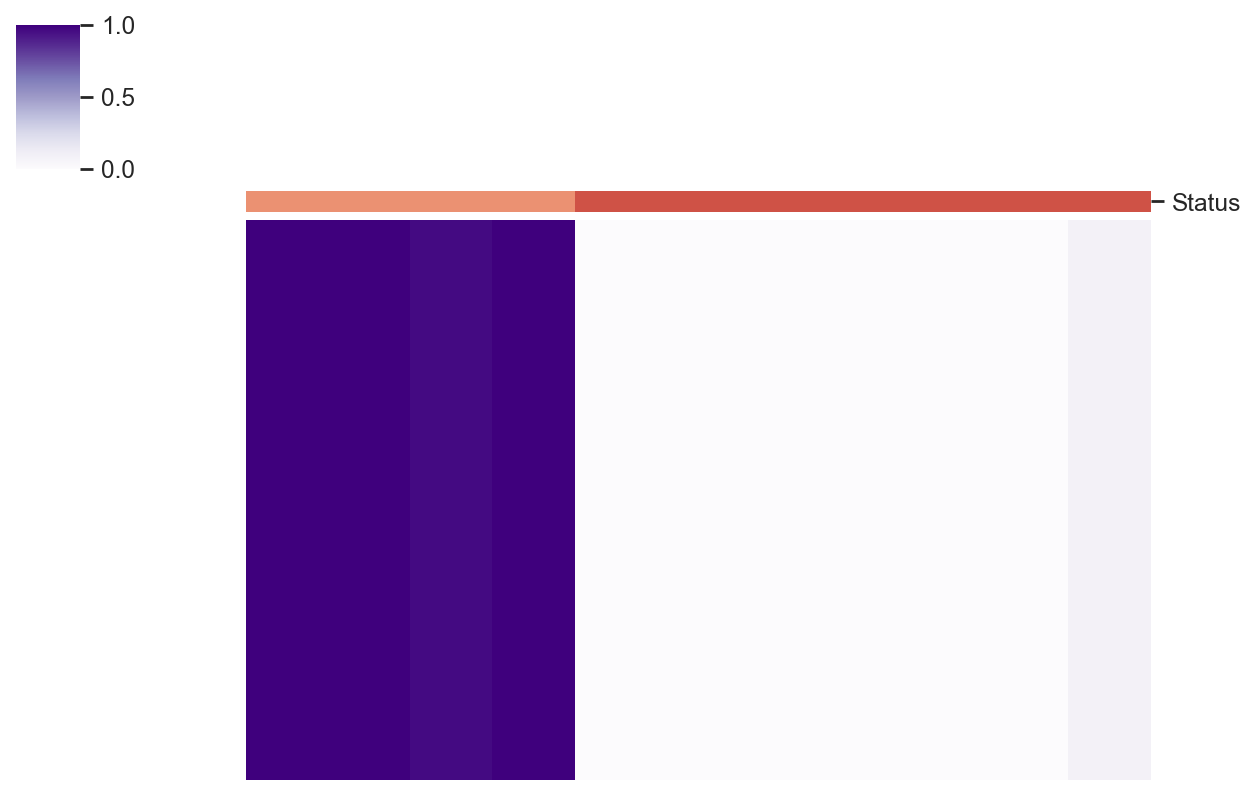

In [204]:
Heatmap(gliomaCellLineScores, [0], clDict, '', '', 1, (8,5), pal=mutationColors, 
        colormap='Purples', geneCluster=False, vMinMax=(0,1), ticks=[0,0.5,1])

[('H3.1', 'H3.3')]


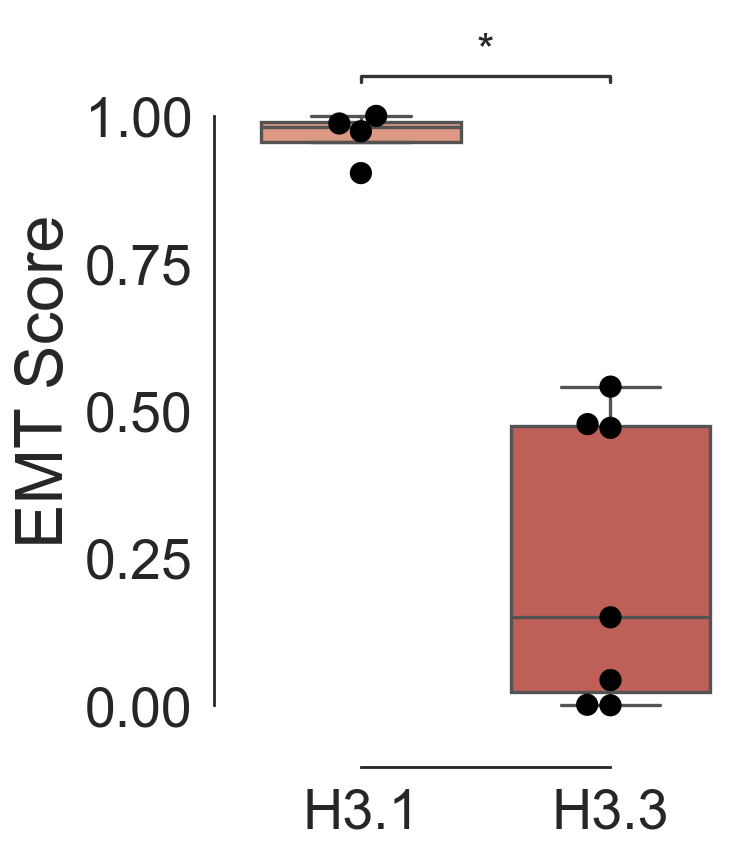

In [205]:
Boxplot(gliomaCellLineScores, 0, clDict, '', 'EMT Score', 'figures/4D-2.png', (4,6),
        color=[sns.color_palette('RdGy', 10)[2],sns.color_palette('RdGy', 10)[1]], swarmSize=10, statLoc='inside' )

# Figure S2

[('H3.1K27M', 'H3.3K27M'), ('H3.1K27M', 'WT'), ('H3.3K27M', 'WT')]


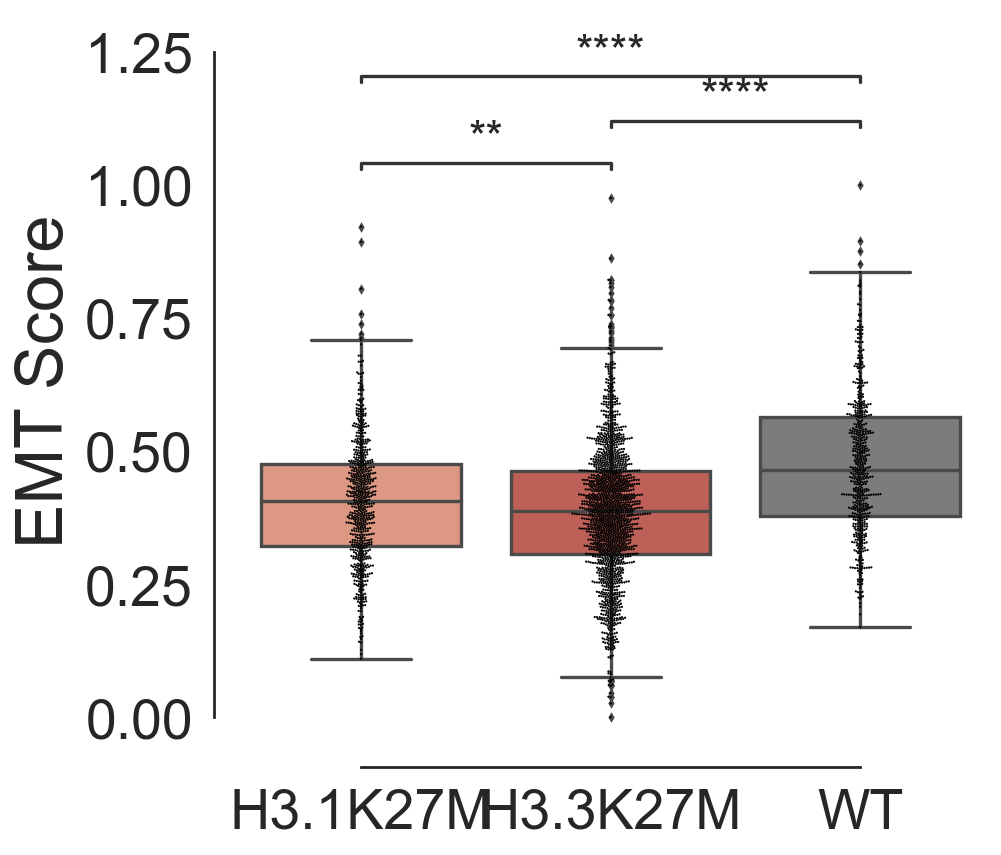

In [206]:
Boxplot(scGliScores, 0, scGliomaDict, '', 'EMT Score', '', (6,6),
        color=mutationColors, swarmSize=1, statLoc='inside' )

# Figure S5

In [217]:
signatures = pd.read_csv('files/aao4750_Filbin_SM_TableS5.csv',sep=',')

In [218]:
cellcycle = list(signatures['Cellcycle'])
OC = list(signatures['OC'])
AC = list(signatures['AC'])
OPC = list(signatures['OPC-variable'])

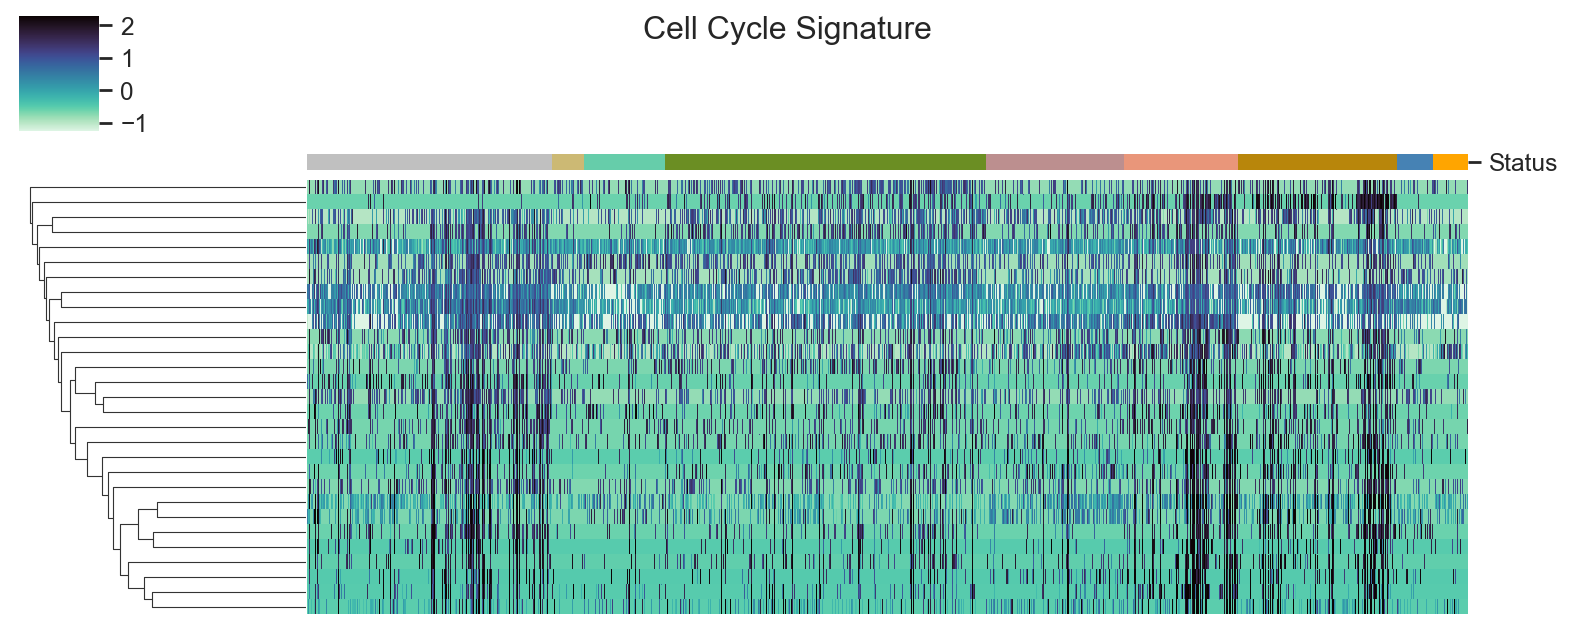

In [219]:
Heatmap(scGlioma, cellcycle, dendrDict, 'Cell Cycle Signature', '', 
        1, (10,4), pal=colors, 
        colormap='mako_r', geneCluster=True, vMinMax=(None,None), ticks=[-1,0,1,2])

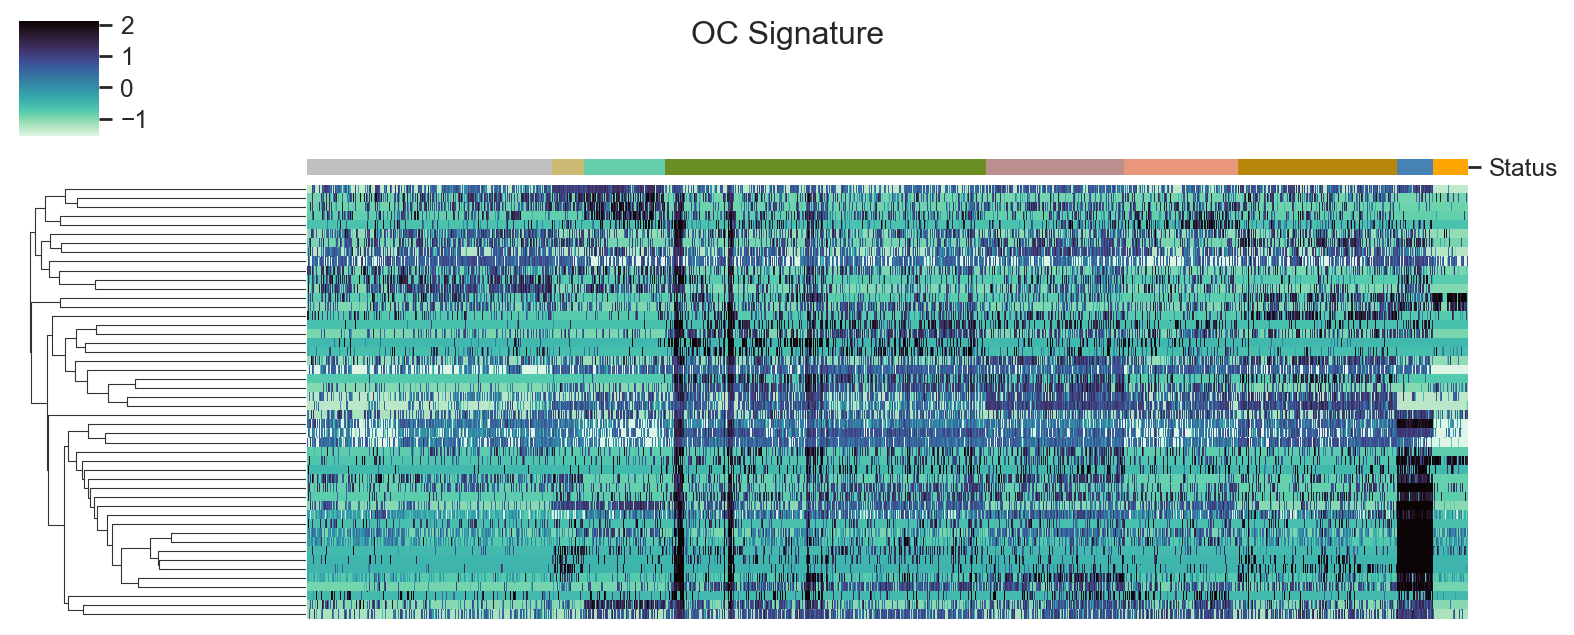

In [220]:
Heatmap(scGlioma, OC, dendrDict, 'OC Signature', '', 1, (10,4), pal=colors, 
        colormap='mako_r', geneCluster=True, vMinMax=(None,None), ticks=[-1,0,1,2])

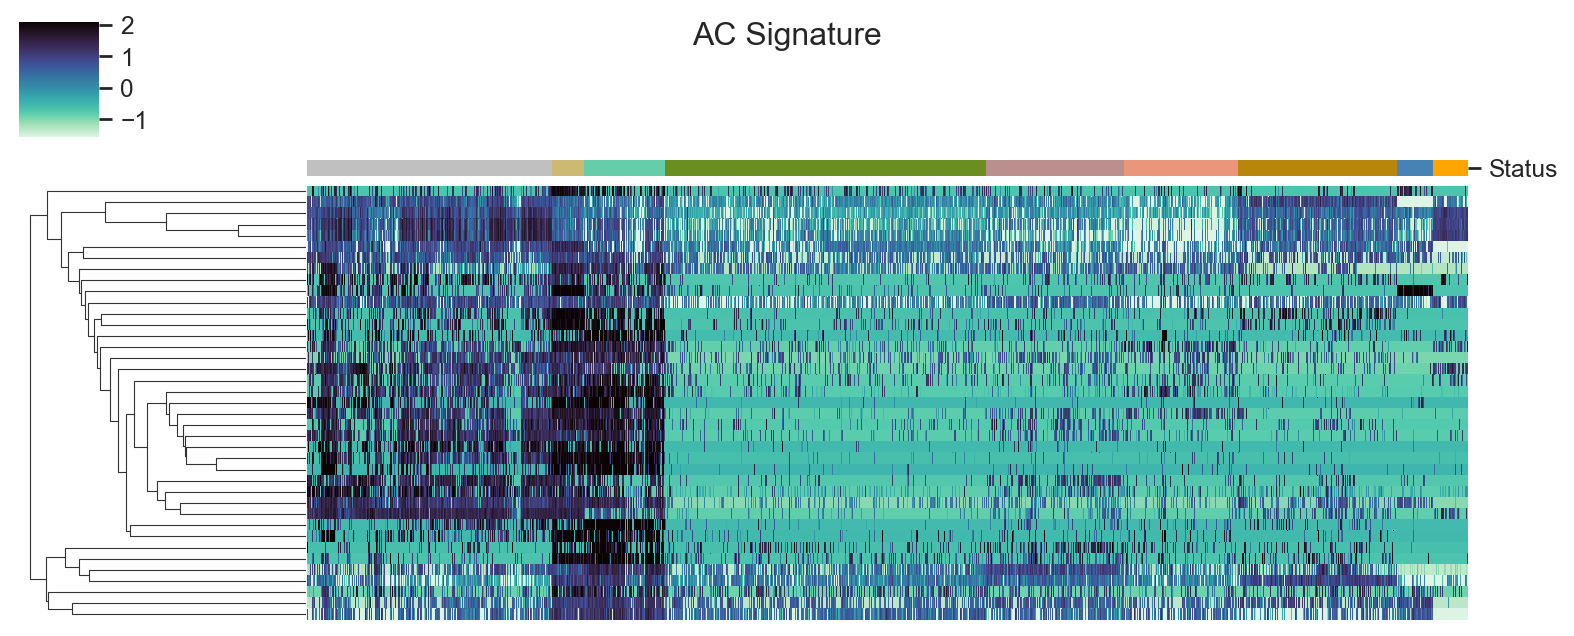

In [221]:
Heatmap(scGlioma, AC, dendrDict, 'AC Signature', '', 1, (10,4), pal=colors, 
        colormap='mako_r', geneCluster=True, vMinMax=(None,None), ticks=[-1,0,1,2])

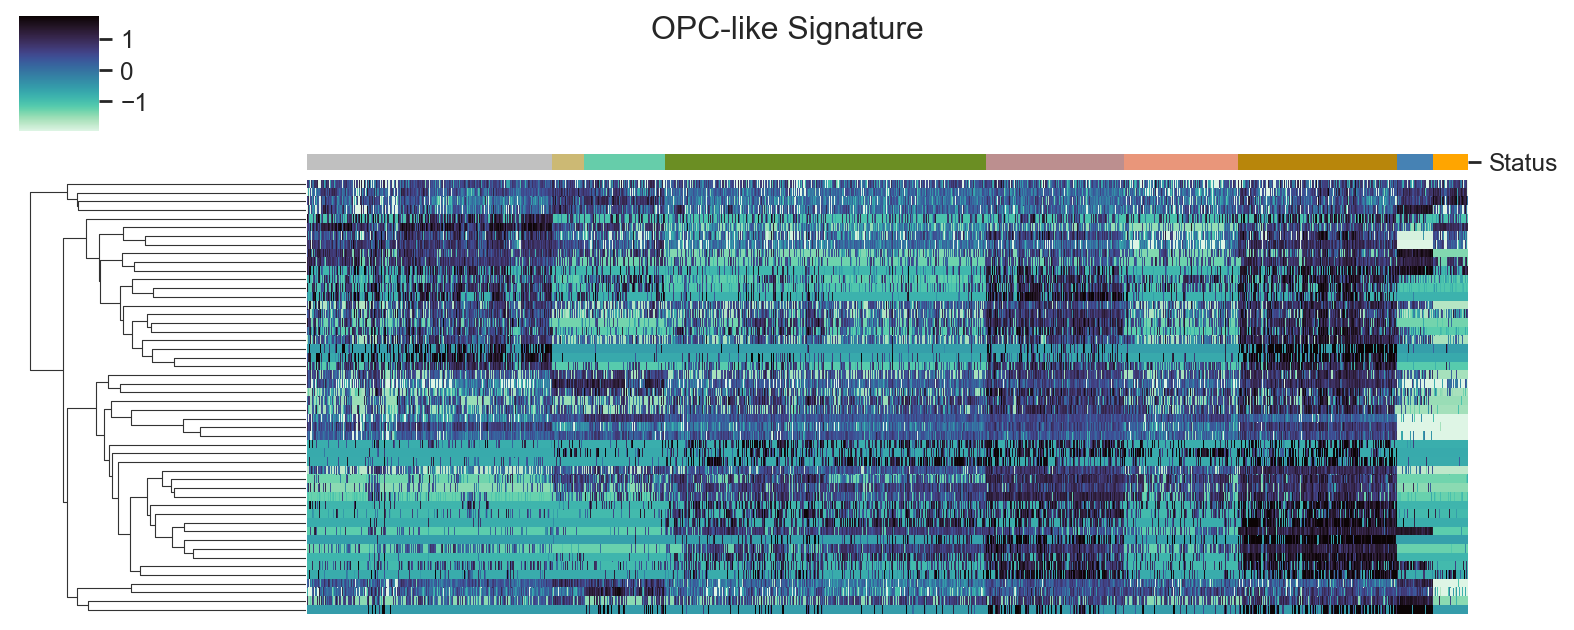

In [222]:
Heatmap(scGlioma, OPC, dendrDict, 'OPC-like Signature', '', 1, (10,4), pal=colors, 
        colormap='mako_r', geneCluster=True, vMinMax=(None,None), ticks=[-1,0,1,2])